# Smart Retail Analytics - Data Mining Lab Project

**Dataset:** UCI Online Retail  
**Name:** [UMER AHMED]  
**Reg No:** FA21-BDS-020  
**Class:** BDS-5

## Project Overview
This project analyzes real-world retail transaction data to explore customer behavior and build predictive models using Python. The dataset contains transactions with InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, and Country.

## Table of Contents
1. [Data Ingestion & Preprocessing](#1-data-ingestion--preprocessing)
2. [Similarity & Dissimilarity Matrices](#2-similarity--dissimilarity-matrices)
3. [Clustering Analysis](#3-clustering-analysis)
4. [Association Rule Mining](#4-association-rule-mining)
5. [Naïve Bayes Classification](#5-naïve-bayes-classification)
6. [Support Vector Machine](#6-support-vector-machine)
7. [Conclusions & Business Recommendations](#7-conclusions--business-recommendations)

## 1. Data Ingestion & Preprocessing

In [92]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [93]:
# Load the dataset
df = pd.read_excel('Online Retail.xlsx')

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nFirst 5 rows:")
df.head()

Dataset shape: (541909, 8)

Column names: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

First 5 rows:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [94]:
# Data exploration
print("Data Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())
print("\nBasic Statistics:")
df.describe()

Data Types:
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

Missing Values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Basic Statistics:


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [95]:
# Data cleaning steps
print(f"Original dataset size: {len(df)}")

# Remove rows with missing CustomerID
df_clean = df.dropna(subset=['CustomerID']).copy()
print(f"After removing missing CustomerIDs: {len(df_clean)}")

# Remove cancellations (InvoiceNo starting with 'C')
df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('C')]
print(f"After removing cancellations: {len(df_clean)}")

# Remove negative quantities and zero prices
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]
print(f"After removing negative quantities and zero prices: {len(df_clean)}")

# Convert CustomerID to integer
df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)

print("\nCleaning completed!")

Original dataset size: 541909
After removing missing CustomerIDs: 406829
After removing cancellations: 397924
After removing negative quantities and zero prices: 397884

Cleaning completed!
After removing cancellations: 397924
After removing negative quantities and zero prices: 397884

Cleaning completed!


In [96]:
# Feature Engineering
# Create TotalAmount feature
df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['UnitPrice']

print(f"TotalAmount statistics:")
print(df_clean['TotalAmount'].describe())

# Check for any extreme outliers
print(f"\nTop 10 highest transaction amounts:")
print(df_clean.nlargest(10, 'TotalAmount')[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice', 'TotalAmount', 'CustomerID']])

TotalAmount statistics:
count    397884.000000
mean         22.397000
std         309.071041
min           0.001000
25%           4.680000
50%          11.800000
75%          19.800000
max      168469.600000
Name: TotalAmount, dtype: float64

Top 10 highest transaction amounts:
       InvoiceNo StockCode                          Description  Quantity  \
540421    581483     23843          PAPER CRAFT , LITTLE BIRDIE     80995   
61619     541431     23166       MEDIUM CERAMIC TOP STORAGE JAR     74215   
222680    556444     22502       PICNIC BASKET WICKER 60 PIECES        60   
173382    551697      POST                              POSTAGE         1   
348325    567423     23243  SET OF TEA COFFEE SUGAR TINS PANTRY      1412   
52711     540815     21108   FAIRY CAKE FLANNEL ASSORTED COLOUR      3114   
160546    550461     21108   FAIRY CAKE FLANNEL ASSORTED COLOUR      3114   
421601    573003     23084                   RABBIT NIGHT LIGHT      2400   
52709     540815    85123A  

In [97]:
# RFM Analysis (Recency, Frequency, Monetary)
# Calculate reference date (latest date in dataset + 1 day)
reference_date = df_clean['InvoiceDate'].max() + timedelta(days=1)
print(f"Reference date for recency calculation: {reference_date}")

# Calculate RFM metrics per customer
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalAmount': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print(f"RFM dataset shape: {rfm.shape}")
print(f"\nRFM statistics:")
print(rfm.describe())

# Display first few rows
print(f"\nFirst 10 customers RFM data:")
rfm.head(10)

Reference date for recency calculation: 2011-12-10 12:50:00
RFM dataset shape: (4338, 4)

RFM statistics:
         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2054.266460
std     1721.808492   100.014169     7.697998    8989.230441
min    12346.000000     1.000000     1.000000       3.750000
25%    13813.250000    18.000000     1.000000     307.415000
50%    15299.500000    51.000000     2.000000     674.485000
75%    16778.750000   142.000000     5.000000    1661.740000
max    18287.000000   374.000000   209.000000  280206.020000

First 10 customers RFM data:
RFM dataset shape: (4338, 4)

RFM statistics:
         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2054.266460
std     1721.808492   100.014169     7.697998    8989.230441
min    12346.000000     1

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,19,1,1757.55
4,12350,310,1,334.40
5,12352,36,8,2506.04
6,12353,204,1,89.00
7,12354,232,1,1079.40
8,12355,214,1,459.40
9,12356,23,3,2811.43


In [98]:
# One-hot encode Country feature
from sklearn.preprocessing import LabelEncoder

# First, let's see the distribution of countries
print("Country distribution:")
print(df_clean['Country'].value_counts().head(10))

# Create country features per customer (most frequent country)
customer_country = df_clean.groupby('CustomerID')['Country'].agg(lambda x: x.mode()[0]).reset_index()

# One-hot encode countries (keeping only top countries to avoid too many features)
top_countries = df_clean['Country'].value_counts().head(10).index.tolist()
customer_country['Country_encoded'] = customer_country['Country'].apply(
    lambda x: x if x in top_countries else 'Other'
)

# Create dummy variables
country_dummies = pd.get_dummies(customer_country['Country_encoded'], prefix='Country')
customer_features = pd.concat([customer_country[['CustomerID']], country_dummies], axis=1)

print(f"\nCountry encoding completed. Shape: {customer_features.shape}")
print(f"Encoded countries: {country_dummies.columns.tolist()}")

Country distribution:
Country
United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Netherlands         2359
Belgium             2031
Switzerland         1841
Portugal            1462
Australia           1182
Name: count, dtype: int64

Country encoding completed. Shape: (4338, 12)
Encoded countries: ['Country_Australia', 'Country_Belgium', 'Country_EIRE', 'Country_France', 'Country_Germany', 'Country_Netherlands', 'Country_Other', 'Country_Portugal', 'Country_Spain', 'Country_Switzerland', 'Country_United Kingdom']

Country encoding completed. Shape: (4338, 12)
Encoded countries: ['Country_Australia', 'Country_Belgium', 'Country_EIRE', 'Country_France', 'Country_Germany', 'Country_Netherlands', 'Country_Other', 'Country_Portugal', 'Country_Spain', 'Country_Switzerland', 'Country_United Kingdom']


In [99]:
# Merge RFM with country features
rfm_final = rfm.merge(customer_features, on='CustomerID', how='left')

print(f"Final RFM dataset shape: {rfm_final.shape}")
print(f"\nFinal dataset columns: {rfm_final.columns.tolist()}")
print(f"\nSample of final preprocessed data:")
rfm_final.head()

Final RFM dataset shape: (4338, 15)

Final dataset columns: ['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Country_Australia', 'Country_Belgium', 'Country_EIRE', 'Country_France', 'Country_Germany', 'Country_Netherlands', 'Country_Other', 'Country_Portugal', 'Country_Spain', 'Country_Switzerland', 'Country_United Kingdom']

Sample of final preprocessed data:


,CustomerID,Recency,Frequency,Monetary,Country_Australia,Country_Belgium,Country_EIRE,Country_France,Country_Germany,Country_Netherlands,Country_Other,Country_Portugal,Country_Spain,Country_Switzerland,Country_United Kingdom
0,12346,326,1,77183.60,False,False,False,False,False,False,False,False,False,False,True
1,12347,2,7,4310.00,False,False,False,False,False,False,True,False,False,False,False
2,12348,75,4,1797.24,False,False,False,False,False,False,True,False,False,False,False
3,12349,19,1,1757.55,False,False,False,False,False,False,True,False,False,False,False
4,12350,310,1,334.40,False,False,False,False,False,False,True,False,False,False,False


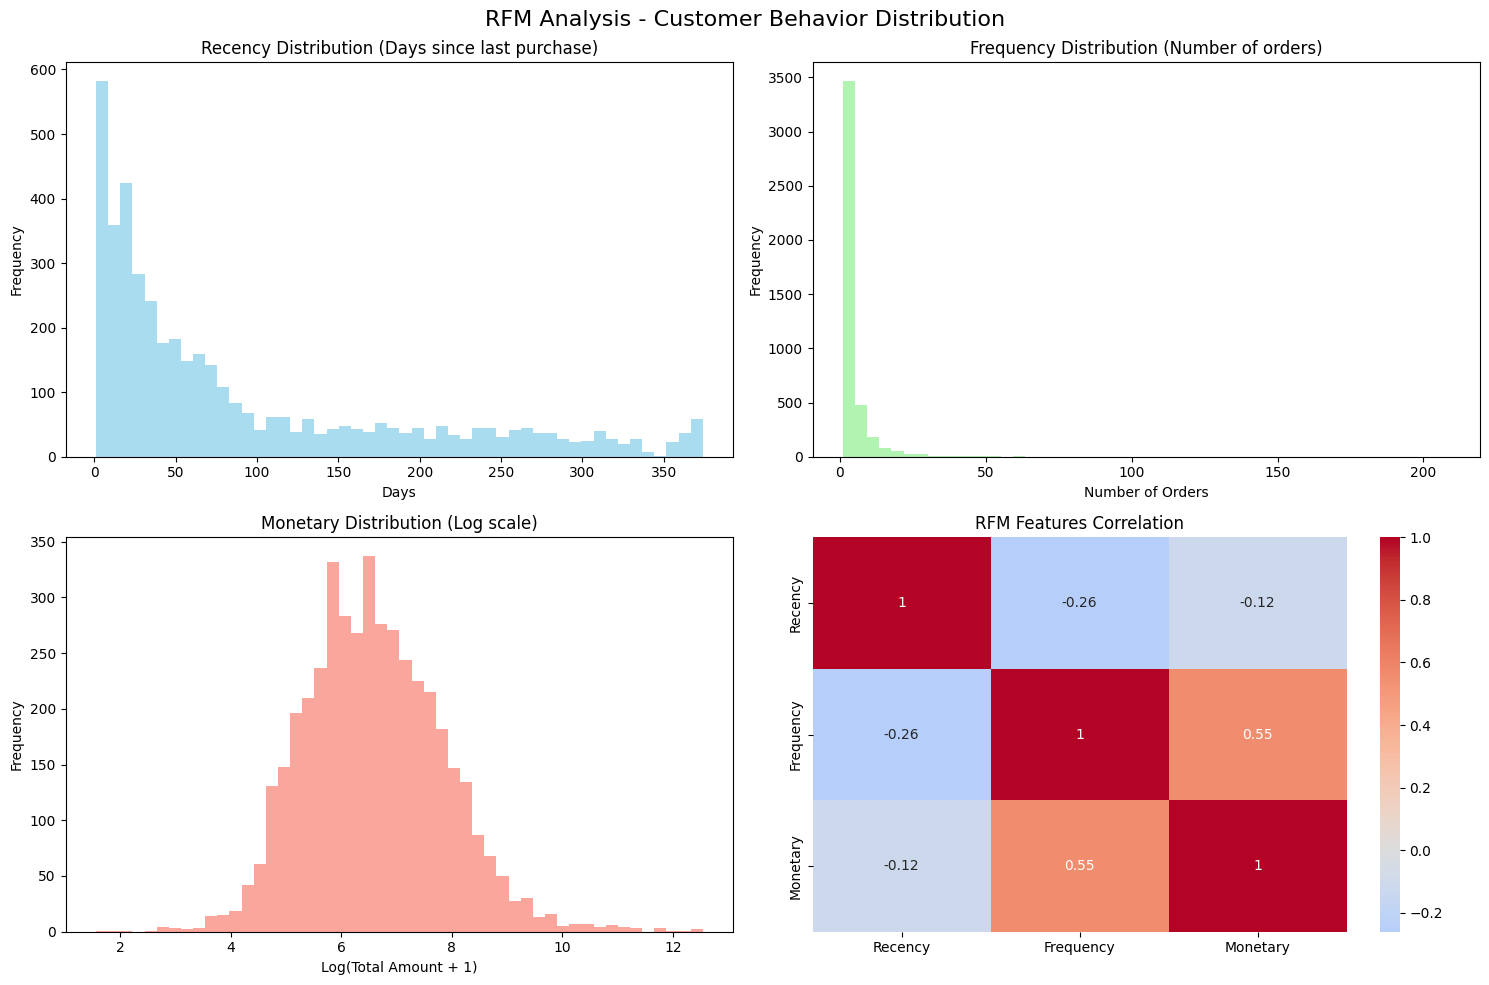

✅ Data Preprocessing Completed!
📊 Ready for analysis with 4338 customers


In [100]:
# Visualize RFM distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('RFM Analysis - Customer Behavior Distribution', fontsize=16)

# Recency distribution
axes[0,0].hist(rfm['Recency'], bins=50, alpha=0.7, color='skyblue')
axes[0,0].set_title('Recency Distribution (Days since last purchase)')
axes[0,0].set_xlabel('Days')
axes[0,0].set_ylabel('Frequency')

# Frequency distribution
axes[0,1].hist(rfm['Frequency'], bins=50, alpha=0.7, color='lightgreen')
axes[0,1].set_title('Frequency Distribution (Number of orders)')
axes[0,1].set_xlabel('Number of Orders')
axes[0,1].set_ylabel('Frequency')

# Monetary distribution (log scale due to skewness)
axes[1,0].hist(np.log1p(rfm['Monetary']), bins=50, alpha=0.7, color='salmon')
axes[1,0].set_title('Monetary Distribution (Log scale)')
axes[1,0].set_xlabel('Log(Total Amount + 1)')
axes[1,0].set_ylabel('Frequency')

# RFM correlation heatmap
rfm_corr = rfm[['Recency', 'Frequency', 'Monetary']].corr()
sns.heatmap(rfm_corr, annot=True, cmap='coolwarm', center=0, ax=axes[1,1])
axes[1,1].set_title('RFM Features Correlation')

plt.tight_layout()
plt.show()

print("✅ Data Preprocessing Completed!")
print(f"📊 Ready for analysis with {len(rfm_final)} customers")

## 2. Similarity & Dissimilarity Matrices

In this section, we'll compute:
- Euclidean distance between customers in RFM space
- Jaccard similarity based on top 10 most purchased products per customer

In [101]:
# Import required libraries for similarity analysis
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances, pairwise_distances
from scipy.spatial.distance import pdist, squareform
import itertools

# Prepare RFM data for distance calculation
rfm_features = rfm[['Recency', 'Frequency', 'Monetary']].copy()

# Standardize RFM features for fair distance calculation
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'])
rfm_scaled_df['CustomerID'] = rfm['CustomerID'].values

print(f"Scaled RFM data shape: {rfm_scaled_df.shape}")
print("\nScaled RFM statistics:")
print(rfm_scaled_df.describe())

Scaled RFM data shape: (4338, 4)

Scaled RFM statistics:
       Recency_scaled  Frequency_scaled  Monetary_scaled    CustomerID
count    4.338000e+03      4.338000e+03     4.338000e+03   4338.000000
mean     2.702618e-17      1.801745e-17     1.801745e-17  15300.408022
std      1.000115e+00      1.000115e+00     1.000115e+00   1721.808492
min     -9.153401e-01     -4.250965e-01    -2.281344e-01  12346.000000
25%     -7.453445e-01     -4.250965e-01    -1.943495e-01  13813.250000
50%     -4.153533e-01     -2.951776e-01    -1.535104e-01  15299.500000
75%      4.946227e-01      9.457903e-02    -4.367134e-02  16778.750000
max      2.814561e+00      2.659803e+01     3.094634e+01  18287.000000


Euclidean distance matrix shape: (50, 50)
Sample distances between first 5 customers:
[[0.         8.76581525 8.76343986 8.93558589 8.55151232]
 [8.76581525 0.         0.87346275 0.84686658 3.20767538]
 [8.76343986 0.87346275 0.         0.68228527 2.38759431]
 [8.93558589 0.84686658 0.68228527 0.         2.91422768]
 [8.55151232 3.20767538 2.38759431 2.91422768 0.        ]]


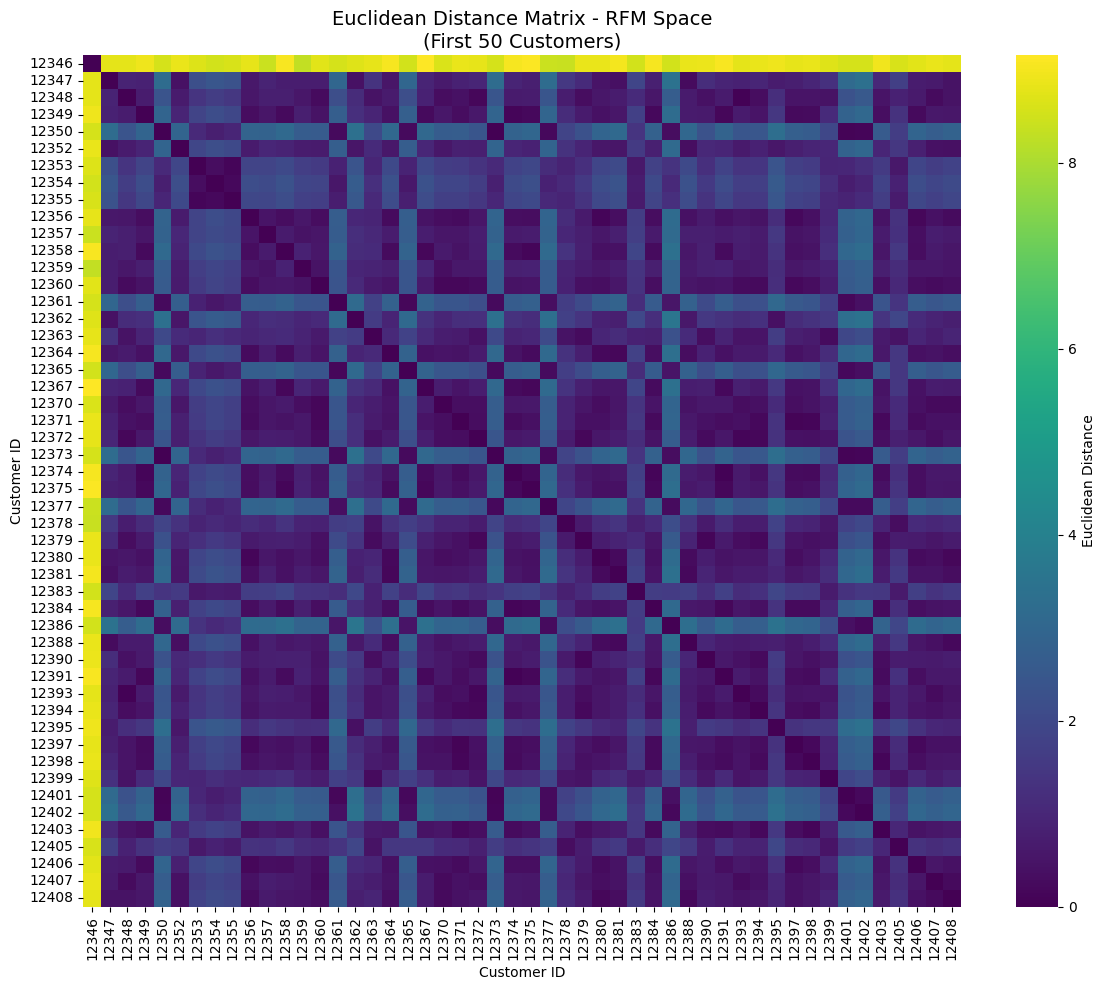

In [102]:
# Calculate Euclidean distance matrix (using subset of customers for visualization)
# Using first 50 customers for computational efficiency and visualization clarity
subset_size = 50
rfm_subset = rfm_scaled[:subset_size]
customer_ids_subset = rfm['CustomerID'].iloc[:subset_size].values

# Compute Euclidean distance matrix
euclidean_dist_matrix = euclidean_distances(rfm_subset)

print(f"Euclidean distance matrix shape: {euclidean_dist_matrix.shape}")
print(f"Sample distances between first 5 customers:")
print(euclidean_dist_matrix[:5, :5])

# Visualize Euclidean distance matrix as heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(euclidean_dist_matrix, 
            xticklabels=customer_ids_subset,
            yticklabels=customer_ids_subset,
            cmap='viridis',
            cbar_kws={'label': 'Euclidean Distance'})
plt.title(f'Euclidean Distance Matrix - RFM Space\n(First {subset_size} Customers)', fontsize=14)
plt.xlabel('Customer ID')
plt.ylabel('Customer ID')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [103]:
# Prepare data for Jaccard similarity (top 10 products per customer)
# Get top purchased products per customer
customer_products = df_clean.groupby(['CustomerID', 'StockCode'])['Quantity'].sum().reset_index()

# Get top 10 products for each customer
top_products_per_customer = customer_products.groupby('CustomerID').apply(
    lambda x: x.nlargest(10, 'Quantity')['StockCode'].tolist()
).reset_index()
top_products_per_customer.columns = ['CustomerID', 'TopProducts']

print(f"Number of customers with product data: {len(top_products_per_customer)}")
print("\nSample top products for first 5 customers:")
for i in range(5):
    customer_id = top_products_per_customer.iloc[i]['CustomerID']
    products = top_products_per_customer.iloc[i]['TopProducts']
    print(f"Customer {customer_id}: {products}")

Number of customers with product data: 4338

Sample top products for first 5 customers:
Customer 12346: [23166]
Customer 12347: [23076, '84558A', 22492, 23084, 21731, 22196, 84991, 84992, 21791, 21975]
Customer 12348: [23077, 23078, 21213, 21967, 21977, 21980, 21981, 21982, 21983, 21985]
Customer 12349: [21231, 21232, 22704, 23545, 21787, 21136, 21086, 22059, 22064, 22195]
Customer 12350: [22348, 20615, 20652, 21171, 21832, 21864, 21866, 21908, 21915, 22412]


Jaccard similarity matrix shape: (50, 50)
Sample Jaccard similarities between first 5 customers:
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


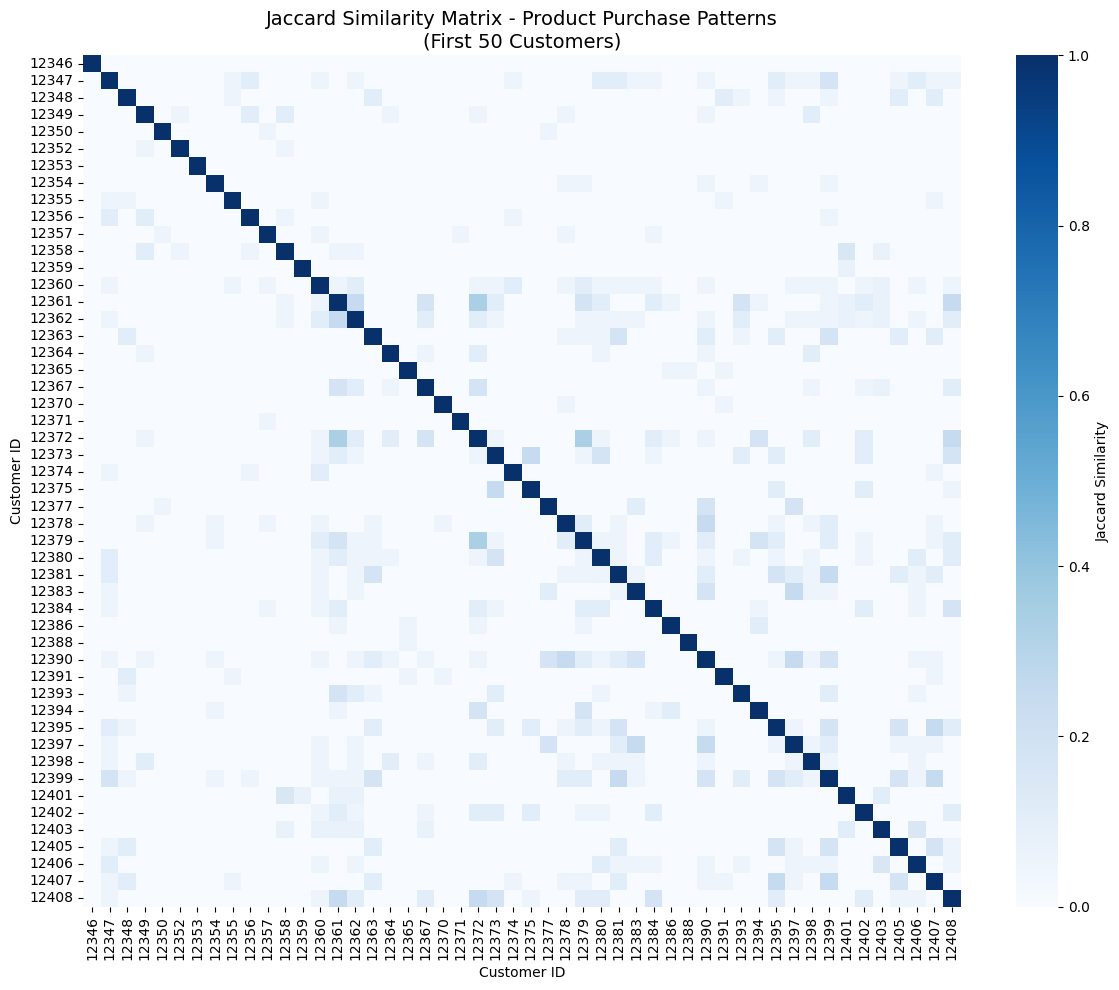

In [104]:
# Calculate Jaccard similarity matrix
def jaccard_similarity(set1, set2):
    """Calculate Jaccard similarity between two sets"""
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0

# Use subset for visualization
top_products_subset = top_products_per_customer.head(subset_size)
n_customers = len(top_products_subset)

# Initialize Jaccard similarity matrix
jaccard_matrix = np.zeros((n_customers, n_customers))

# Calculate pairwise Jaccard similarities
for i in range(n_customers):
    for j in range(n_customers):
        if i == j:
            jaccard_matrix[i, j] = 1.0  # Self-similarity
        else:
            set1 = set(top_products_subset.iloc[i]['TopProducts'])
            set2 = set(top_products_subset.iloc[j]['TopProducts'])
            jaccard_matrix[i, j] = jaccard_similarity(set1, set2)

print(f"Jaccard similarity matrix shape: {jaccard_matrix.shape}")
print(f"Sample Jaccard similarities between first 5 customers:")
print(jaccard_matrix[:5, :5])

# Visualize Jaccard similarity matrix
plt.figure(figsize=(12, 10))
customer_ids_subset_jaccard = top_products_subset['CustomerID'].values
sns.heatmap(jaccard_matrix,
            xticklabels=customer_ids_subset_jaccard,
            yticklabels=customer_ids_subset_jaccard,
            cmap='Blues',
            vmin=0, vmax=1,
            cbar_kws={'label': 'Jaccard Similarity'})
plt.title(f'Jaccard Similarity Matrix - Product Purchase Patterns\n(First {subset_size} Customers)', fontsize=14)
plt.xlabel('Customer ID')
plt.ylabel('Customer ID')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [105]:
# Analysis of similarity matrices
print("📊 SIMILARITY ANALYSIS SUMMARY")
print("=" * 40)

# Euclidean distance analysis
print("\n🔹 Euclidean Distance Analysis (RFM Space):")
non_diag_euclidean = euclidean_dist_matrix[np.triu_indices_from(euclidean_dist_matrix, k=1)]
print(f"   • Average distance between customers: {non_diag_euclidean.mean():.3f}")
print(f"   • Min distance: {non_diag_euclidean.min():.3f}")
print(f"   • Max distance: {non_diag_euclidean.max():.3f}")
print(f"   • Standard deviation: {non_diag_euclidean.std():.3f}")

# Jaccard similarity analysis
print("\n🔹 Jaccard Similarity Analysis (Product Overlap):")
non_diag_jaccard = jaccard_matrix[np.triu_indices_from(jaccard_matrix, k=1)]
print(f"   • Average similarity: {non_diag_jaccard.mean():.3f}")
print(f"   • Min similarity: {non_diag_jaccard.min():.3f}")
print(f"   • Max similarity: {non_diag_jaccard.max():.3f}")
print(f"   • Standard deviation: {non_diag_jaccard.std():.3f}")

# Find most similar and dissimilar customer pairs
max_jaccard_idx = np.unravel_index(np.argmax(jaccard_matrix - np.eye(n_customers)), jaccard_matrix.shape)
min_euclidean_idx = np.unravel_index(np.argmin(euclidean_dist_matrix + np.eye(subset_size) * 1000), euclidean_dist_matrix.shape)

print(f"\n🔹 Most Similar Customers:")
print(f"   • By product overlap: Customers {customer_ids_subset_jaccard[max_jaccard_idx[0]]} & {customer_ids_subset_jaccard[max_jaccard_idx[1]]} (Jaccard: {jaccard_matrix[max_jaccard_idx]:.3f})")
print(f"   • By RFM behavior: Customers {customer_ids_subset[min_euclidean_idx[0]]} & {customer_ids_subset[min_euclidean_idx[1]]} (Distance: {euclidean_dist_matrix[min_euclidean_idx]:.3f})")

print("\n✅ Similarity & Dissimilarity Analysis Completed!")

📊 SIMILARITY ANALYSIS SUMMARY

🔹 Euclidean Distance Analysis (RFM Space):
   • Average distance between customers: 1.602
   • Min distance: 0.011
   • Max distance: 9.153
   • Standard deviation: 1.734

🔹 Jaccard Similarity Analysis (Product Overlap):
   • Average similarity: 0.017
   • Min similarity: 0.000
   • Max similarity: 0.333
   • Standard deviation: 0.044

🔹 Most Similar Customers:
   • By product overlap: Customers 12361 & 12372 (Jaccard: 0.333)
   • By RFM behavior: Customers 12350 & 12373 (Distance: 0.011)

✅ Similarity & Dissimilarity Analysis Completed!


## 3. Clustering Analysis

We'll perform customer segmentation using:
- K-Means clustering with optimal K selection
- DBSCAN clustering with parameter tuning

In [106]:
# Import clustering libraries
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.patches as patches

# Prepare data for clustering (using scaled RFM features)
X_clustering = rfm_scaled

print(f"Data for clustering shape: {X_clustering.shape}")
print("Using standardized RFM features for clustering...")

Data for clustering shape: (4338, 3)
Using standardized RFM features for clustering...


Finding optimal K for K-Means clustering...
K=2: Inertia=9012.64, Silhouette Score=0.896
K=2: Inertia=9012.64, Silhouette Score=0.896
K=3: Inertia=5439.30, Silhouette Score=0.594
K=3: Inertia=5439.30, Silhouette Score=0.594
K=4: Inertia=4092.14, Silhouette Score=0.616
K=4: Inertia=4092.14, Silhouette Score=0.616
K=5: Inertia=3118.28, Silhouette Score=0.617
K=5: Inertia=3118.28, Silhouette Score=0.617
K=6: Inertia=2472.57, Silhouette Score=0.596
K=6: Inertia=2472.57, Silhouette Score=0.596
K=7: Inertia=2022.41, Silhouette Score=0.516
K=7: Inertia=2022.41, Silhouette Score=0.516
K=8: Inertia=1742.37, Silhouette Score=0.517
K=8: Inertia=1742.37, Silhouette Score=0.517
K=9: Inertia=1445.63, Silhouette Score=0.478
K=9: Inertia=1445.63, Silhouette Score=0.478
K=10: Inertia=1303.39, Silhouette Score=0.427
K=10: Inertia=1303.39, Silhouette Score=0.427


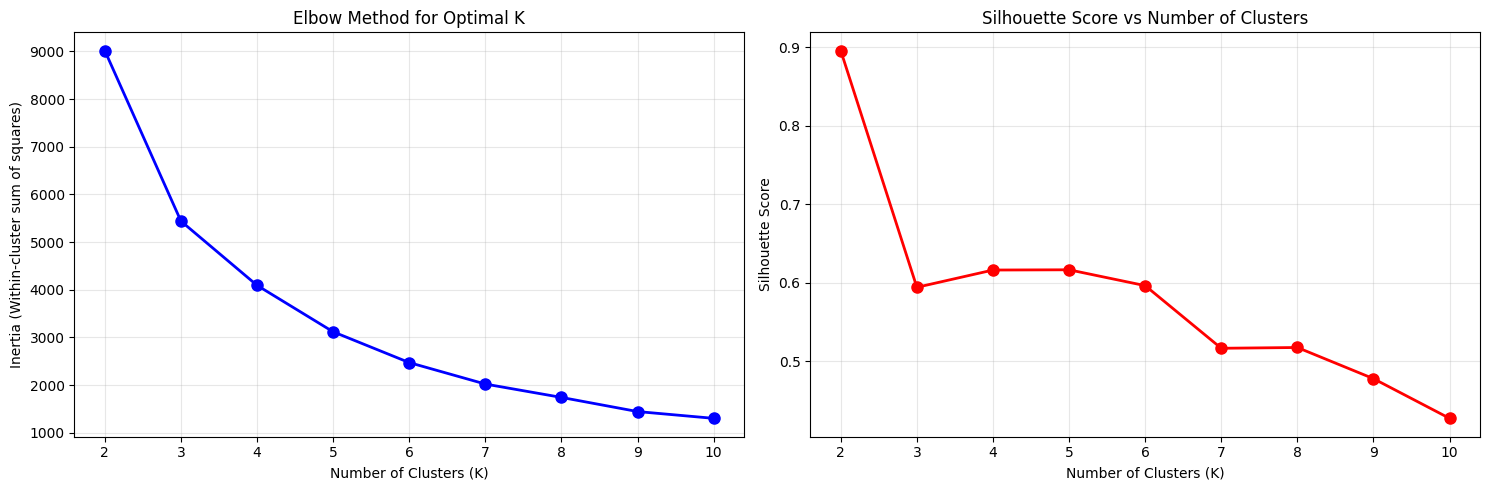


🏆 Optimal K selected: 2 (Silhouette Score: 0.896)


In [107]:
# K-Means: Find optimal number of clusters using Elbow Method
K_range = range(2, 11)
inertias = []
silhouette_scores = []

print("Finding optimal K for K-Means clustering...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_clustering)
    
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_clustering, cluster_labels)
    silhouette_scores.append(sil_score)
    
    print(f"K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette Score={sil_score:.3f}")

# Plot Elbow Curve and Silhouette Scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow plot
ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Inertia (Within-cluster sum of squares)')
ax1.set_title('Elbow Method for Optimal K')
ax1.grid(True, alpha=0.3)

# Silhouette score plot
ax2.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs Number of Clusters')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Select optimal K (highest silhouette score)
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\n🏆 Optimal K selected: {optimal_k} (Silhouette Score: {max(silhouette_scores):.3f})")

In [108]:
# Apply K-Means with optimal K
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_optimal.fit_predict(X_clustering)

# Add cluster labels to RFM data
rfm_clustered = rfm.copy()
rfm_clustered['KMeans_Cluster'] = kmeans_labels

print(f"K-Means clustering completed with K={optimal_k}")
print(f"\nCluster distribution:")
print(rfm_clustered['KMeans_Cluster'].value_counts().sort_index())

# Analyze cluster characteristics
print(f"\n📊 K-Means Cluster Characteristics:")
cluster_summary = rfm_clustered.groupby('KMeans_Cluster')[['Recency', 'Frequency', 'Monetary']].agg(['mean', 'std'])
print(cluster_summary.round(2))

K-Means clustering completed with K=2

Cluster distribution:
KMeans_Cluster
0    4312
1      26
Name: count, dtype: int64

📊 K-Means Cluster Characteristics:
               Recency         Frequency         Monetary          
                  mean     std      mean    std      mean       std
KMeans_Cluster                                                     
0                93.06  100.09      3.90   4.71   1548.68   3091.20
1                 6.04    8.60     66.42  49.13  85904.35  70812.11


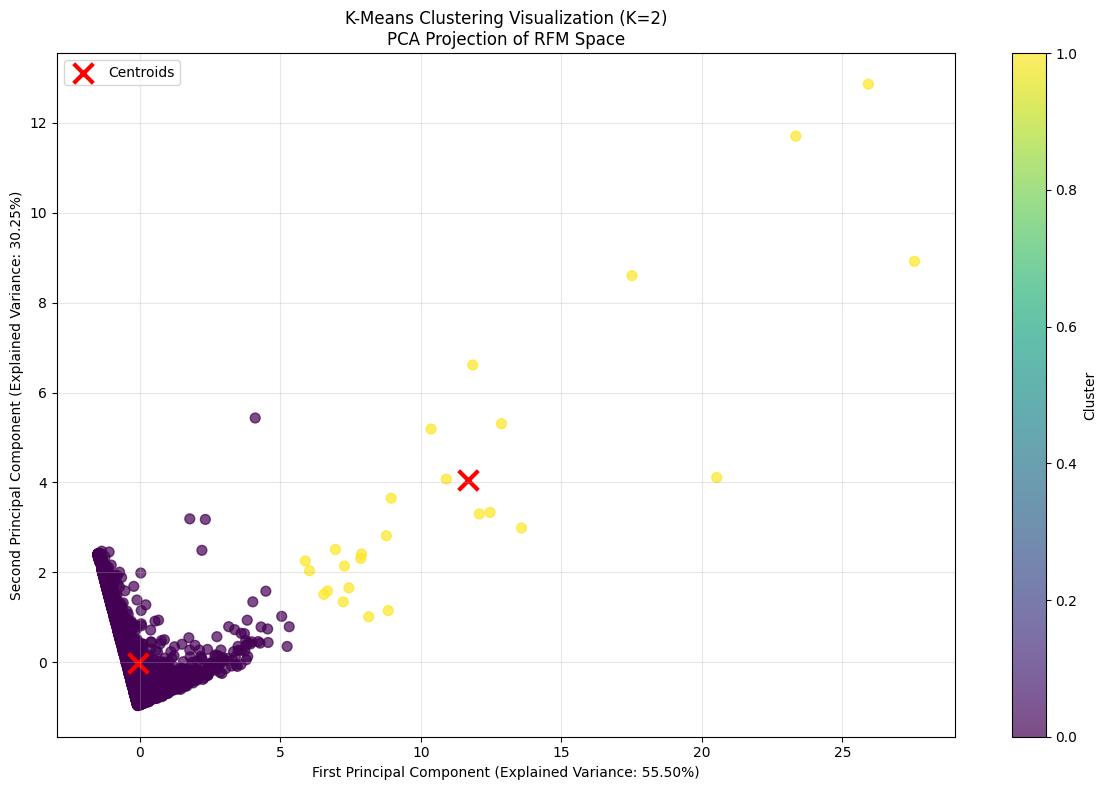

PCA Explained Variance Ratio: [0.55502102 0.30249315]
Total Explained Variance: 85.75%


In [109]:
# Visualize K-Means clusters using PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_clustering)

# Create scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, 
                    cmap='viridis', alpha=0.7, s=50)
plt.colorbar(scatter, label='Cluster')

# Plot cluster centers in PCA space
centers_pca = pca.transform(kmeans_optimal.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], 
           c='red', marker='x', s=200, linewidths=3, label='Centroids')

plt.xlabel(f'First Principal Component (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'Second Principal Component (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})')
plt.title(f'K-Means Clustering Visualization (K={optimal_k})\nPCA Projection of RFM Space')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"PCA Explained Variance Ratio: {pca.explained_variance_ratio_}")
print(f"Total Explained Variance: {pca.explained_variance_ratio_.sum():.2%}")


🔄 DBSCAN CLUSTERING


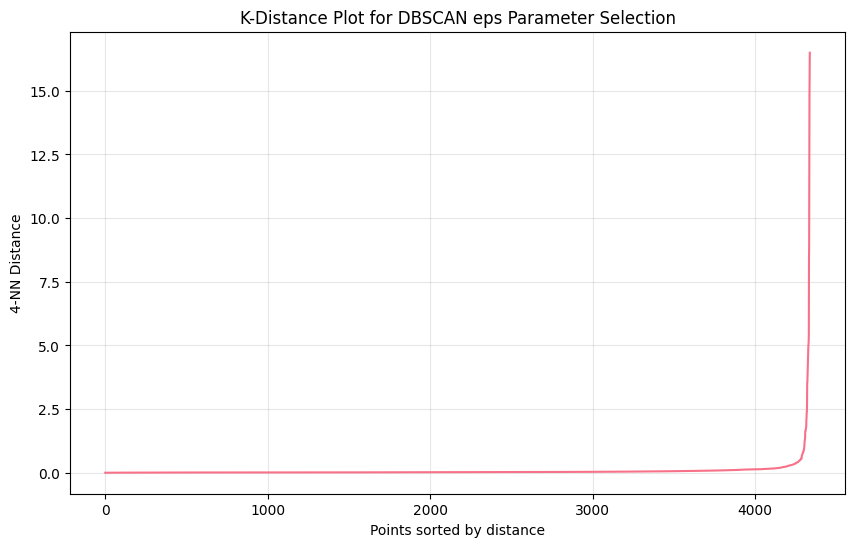

Testing DBSCAN parameters...
eps=0.5, min_samples=3: 1 clusters, 50 noise points, silhouette=-1.000
eps=0.5, min_samples=3: 1 clusters, 50 noise points, silhouette=-1.000
eps=0.5, min_samples=5: 1 clusters, 54 noise points, silhouette=-1.000
eps=0.5, min_samples=5: 1 clusters, 54 noise points, silhouette=-1.000
eps=0.5, min_samples=7: 1 clusters, 65 noise points, silhouette=-1.000
eps=0.5, min_samples=7: 1 clusters, 65 noise points, silhouette=-1.000
eps=0.5, min_samples=10: 2 clusters, 67 noise points, silhouette=0.649
eps=0.5, min_samples=10: 2 clusters, 67 noise points, silhouette=0.649
eps=0.8, min_samples=3: 3 clusters, 31 noise points, silhouette=0.634
eps=0.8, min_samples=3: 3 clusters, 31 noise points, silhouette=0.634
eps=0.8, min_samples=5: 1 clusters, 41 noise points, silhouette=-1.000
eps=0.8, min_samples=5: 1 clusters, 41 noise points, silhouette=-1.000
eps=0.8, min_samples=7: 1 clusters, 44 noise points, silhouette=-1.000
eps=0.8, min_samples=7: 1 clusters, 44 noise point

In [110]:
# DBSCAN Clustering
print("\n" + "="*50)
print("🔄 DBSCAN CLUSTERING")
print("="*50)

# Parameter tuning for DBSCAN
from sklearn.neighbors import NearestNeighbors

# Find optimal eps using k-distance plot
k = 4  # MinPts = k + 1 = 5
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_clustering)
distances, indices = neighbors_fit.kneighbors(X_clustering)
distances = np.sort(distances[:, k-1], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(range(len(distances)), distances)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-NN Distance')
plt.title('K-Distance Plot for DBSCAN eps Parameter Selection')
plt.grid(True, alpha=0.3)
plt.show()

# Test different eps and min_samples values
eps_values = [0.5, 0.8, 1.0, 1.2, 1.5]
min_samples_values = [3, 5, 7, 10]

dbscan_results = []

print("Testing DBSCAN parameters...")
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_clustering)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        if n_clusters > 1:  # Only calculate silhouette for valid clusterings
            sil_score = silhouette_score(X_clustering, labels) if n_clusters > 1 and n_noise < len(labels) else -1
        else:
            sil_score = -1
            
        dbscan_results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': sil_score
        })
        
        print(f"eps={eps}, min_samples={min_samples}: {n_clusters} clusters, {n_noise} noise points, silhouette={sil_score:.3f}")

# Select best DBSCAN parameters
valid_results = [r for r in dbscan_results if r['silhouette'] > 0 and r['n_clusters'] > 1]
if valid_results:
    best_dbscan = max(valid_results, key=lambda x: x['silhouette'])
    print(f"\n🏆 Best DBSCAN parameters: eps={best_dbscan['eps']}, min_samples={best_dbscan['min_samples']}")
    print(f"   Silhouette Score: {best_dbscan['silhouette']:.3f}")
else:
    # Fallback parameters
    best_dbscan = {'eps': 1.0, 'min_samples': 5}
    print(f"\n⚠️ Using fallback DBSCAN parameters: eps={best_dbscan['eps']}, min_samples={best_dbscan['min_samples']}")


DBSCAN Results:
   • Number of clusters: 3
   • Number of noise points: 23
   • Percentage of noise: 0.5%

DBSCAN Cluster distribution:
   Noise points: 23
   Cluster 0: 4307 points
   Cluster 1: 4 points
   Cluster 2: 4 points


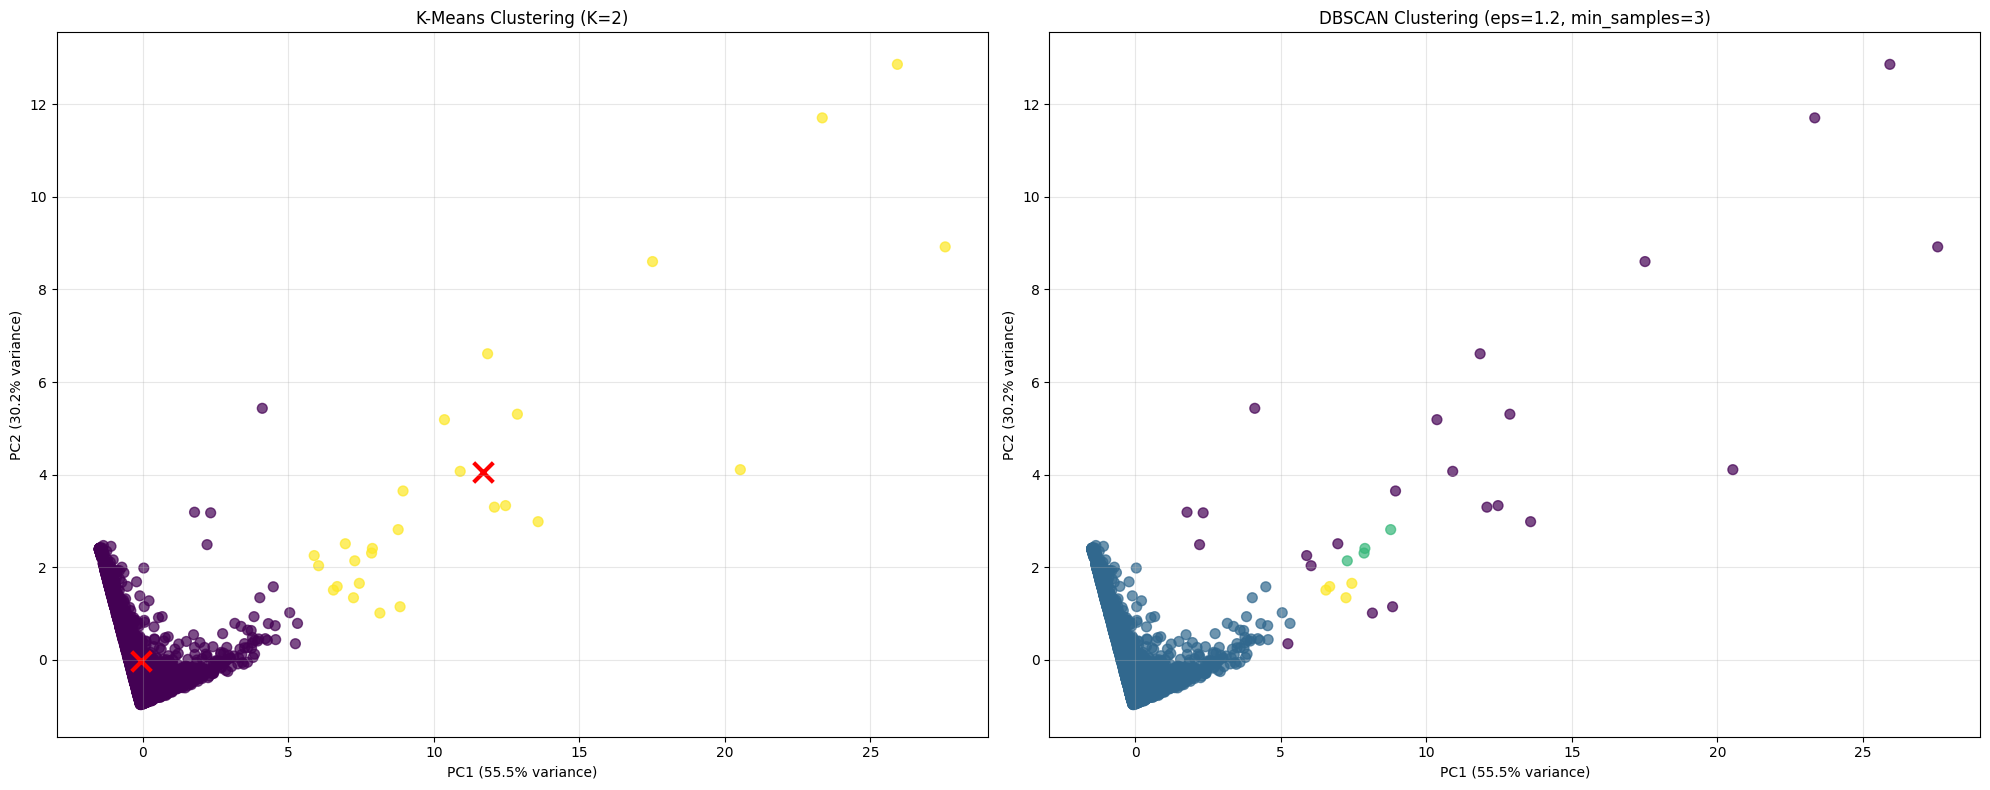


✅ Clustering Analysis Completed!


In [111]:
# Apply DBSCAN with best parameters
dbscan_optimal = DBSCAN(eps=best_dbscan['eps'], min_samples=best_dbscan['min_samples'])
dbscan_labels = dbscan_optimal.fit_predict(X_clustering)

# Add DBSCAN labels to RFM data
rfm_clustered['DBSCAN_Cluster'] = dbscan_labels

# Analyze DBSCAN results
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"\nDBSCAN Results:")
print(f"   • Number of clusters: {n_clusters_dbscan}")
print(f"   • Number of noise points: {n_noise}")
print(f"   • Percentage of noise: {n_noise/len(dbscan_labels)*100:.1f}%")

if n_clusters_dbscan > 0:
    print(f"\nDBSCAN Cluster distribution:")
    unique, counts = np.unique(dbscan_labels, return_counts=True)
    for cluster, count in zip(unique, counts):
        if cluster == -1:
            print(f"   Noise points: {count}")
        else:
            print(f"   Cluster {cluster}: {count} points")

# Visualize DBSCAN clusters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# K-Means visualization
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, 
                      cmap='viridis', alpha=0.7, s=50)
ax1.scatter(centers_pca[:, 0], centers_pca[:, 1], 
           c='red', marker='x', s=200, linewidths=3)
ax1.set_title(f'K-Means Clustering (K={optimal_k})')
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax1.grid(True, alpha=0.3)

# DBSCAN visualization
scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, 
                      cmap='viridis', alpha=0.7, s=50)
ax2.set_title(f'DBSCAN Clustering (eps={best_dbscan["eps"]}, min_samples={best_dbscan["min_samples"]})')
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Clustering Analysis Completed!")

In [112]:
# Compare clustering results
print("📊 CLUSTERING COMPARISON")
print("=" * 40)

# K-Means analysis
if optimal_k > 1:
    kmeans_silhouette = silhouette_score(X_clustering, kmeans_labels)
    print(f"\n🔹 K-Means (K={optimal_k}):")
    print(f"   • Silhouette Score: {kmeans_silhouette:.3f}")
    print(f"   • All points clustered (no noise)")
    
    # Cluster interpretation
    print(f"\n   📊 Cluster Insights:")
    for cluster in sorted(rfm_clustered['KMeans_Cluster'].unique()):
        cluster_data = rfm_clustered[rfm_clustered['KMeans_Cluster'] == cluster]
        avg_recency = cluster_data['Recency'].mean()
        avg_frequency = cluster_data['Frequency'].mean()
        avg_monetary = cluster_data['Monetary'].mean()
        
        # Classify cluster type
        if avg_recency < rfm['Recency'].median() and avg_frequency > rfm['Frequency'].median():
            cluster_type = "Active Customers"
        elif avg_monetary > rfm['Monetary'].quantile(0.75):
            cluster_type = "High Value Customers"
        elif avg_recency > rfm['Recency'].quantile(0.75):
            cluster_type = "At-Risk/Dormant Customers"
        else:
            cluster_type = "Regular Customers"
            
        print(f"      Cluster {cluster} ({len(cluster_data)} customers): {cluster_type}")
        print(f"         R={avg_recency:.0f} days, F={avg_frequency:.1f} orders, M=${avg_monetary:.0f}")

# DBSCAN analysis
if n_clusters_dbscan > 1:
    # Calculate silhouette only for non-noise points
    non_noise_mask = dbscan_labels != -1
    if np.sum(non_noise_mask) > 1:
        dbscan_silhouette = silhouette_score(X_clustering[non_noise_mask], dbscan_labels[non_noise_mask])
        print(f"\n🔹 DBSCAN (eps={best_dbscan['eps']}, min_samples={best_dbscan['min_samples']}):")
        print(f"   • Silhouette Score: {dbscan_silhouette:.3f} (excluding noise)")
        print(f"   • Identified {n_noise} outlier customers ({n_noise/len(dbscan_labels)*100:.1f}% noise)")
        print(f"   • Found {n_clusters_dbscan} natural clusters")
else:
    print(f"\n🔹 DBSCAN: Unable to find meaningful clusters with tested parameters")

print(f"\n📁 Final clustered dataset shape: {rfm_clustered.shape}")
print(f"Columns: {rfm_clustered.columns.tolist()}")

📊 CLUSTERING COMPARISON

🔹 K-Means (K=2):
   • Silhouette Score: 0.896
   • All points clustered (no noise)

   📊 Cluster Insights:
      Cluster 0 (4312 customers): Regular Customers
         R=93 days, F=3.9 orders, M=$1549
      Cluster 1 (26 customers): Active Customers
         R=6 days, F=66.4 orders, M=$85904

🔹 K-Means (K=2):
   • Silhouette Score: 0.896
   • All points clustered (no noise)

   📊 Cluster Insights:
      Cluster 0 (4312 customers): Regular Customers
         R=93 days, F=3.9 orders, M=$1549
      Cluster 1 (26 customers): Active Customers
         R=6 days, F=66.4 orders, M=$85904

🔹 DBSCAN (eps=1.2, min_samples=3):
   • Silhouette Score: 0.815 (excluding noise)
   • Identified 23 outlier customers (0.5% noise)
   • Found 3 natural clusters

📁 Final clustered dataset shape: (4338, 6)
Columns: ['CustomerID', 'Recency', 'Frequency', 'Monetary', 'KMeans_Cluster', 'DBSCAN_Cluster']

🔹 DBSCAN (eps=1.2, min_samples=3):
   • Silhouette Score: 0.815 (excluding noise)
  

## 4. Association Rule Mining

We'll discover frequent itemsets and association rules using:
- Apriori algorithm
- FP-Growth algorithm

Both will be applied to market basket analysis to find product associations.

In [113]:
# Import association rule mining libraries
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
import time

# Prepare market basket data
print("Preparing market basket data for association rule mining...")

# Create transaction data (each invoice as a transaction)
transactions = df_clean.copy()
transactions['StockCode'] = transactions['StockCode'].astype(str)
transactions = transactions.groupby('InvoiceNo')['StockCode'].apply(list).reset_index()
transactions.columns = ['InvoiceNo', 'Items']

print(f"Total transactions: {len(transactions)}")
print(f"Sample transactions:")
for i in range(3):
    print(f"  Invoice {transactions.iloc[i]['InvoiceNo']}: {transactions.iloc[i]['Items'][:10]}...")  # Show first 10 items

# Get transaction lists
transaction_list = transactions['Items'].tolist()

# Remove transactions with only 1 item (can't form associations)
transaction_list = [transaction for transaction in transaction_list if len(transaction) > 1]
print(f"Transactions with 2+ items: {len(transaction_list)}")

Preparing market basket data for association rule mining...
Total transactions: 18532
Sample transactions:
  Invoice 536365: ['85123A', '71053', '84406B', '84029G', '84029E', '22752', '21730']...
  Invoice 536366: ['22633', '22632']...
  Invoice 536367: ['84879', '22745', '22748', '22749', '22310', '84969', '22623', '22622', '21754', '21755']...
Transactions with 2+ items: 17138
Total transactions: 18532
Sample transactions:
  Invoice 536365: ['85123A', '71053', '84406B', '84029G', '84029E', '22752', '21730']...
  Invoice 536366: ['22633', '22632']...
  Invoice 536367: ['84879', '22745', '22748', '22749', '22310', '84969', '22623', '22622', '21754', '21755']...
Transactions with 2+ items: 17138


Encoded transaction matrix shape: (17138, 3661)
Number of unique items: 3661

Top 20 most frequent items:
85123A    0.114307
22423     0.098144
85099B    0.092543
84879     0.080114
47566     0.079589
20725     0.075155
22720     0.066344
23203     0.062960
20727     0.061267
POST      0.061092
22383     0.060859
21212     0.060042
22197     0.059167
23298     0.058642
23209     0.058583
22382     0.057650
22086     0.056774
22457     0.056366
20728     0.056308
22469     0.055841
dtype: float64

Items with support >= 0.01: 688
Filtered transaction matrix shape: (17138, 688)

Top 20 most frequent items:
85123A    0.114307
22423     0.098144
85099B    0.092543
84879     0.080114
47566     0.079589
20725     0.075155
22720     0.066344
23203     0.062960
20727     0.061267
POST      0.061092
22383     0.060859
21212     0.060042
22197     0.059167
23298     0.058642
23209     0.058583
22382     0.057650
22086     0.056774
22457     0.056366
20728     0.056308
22469     0.055841
dtype: fl

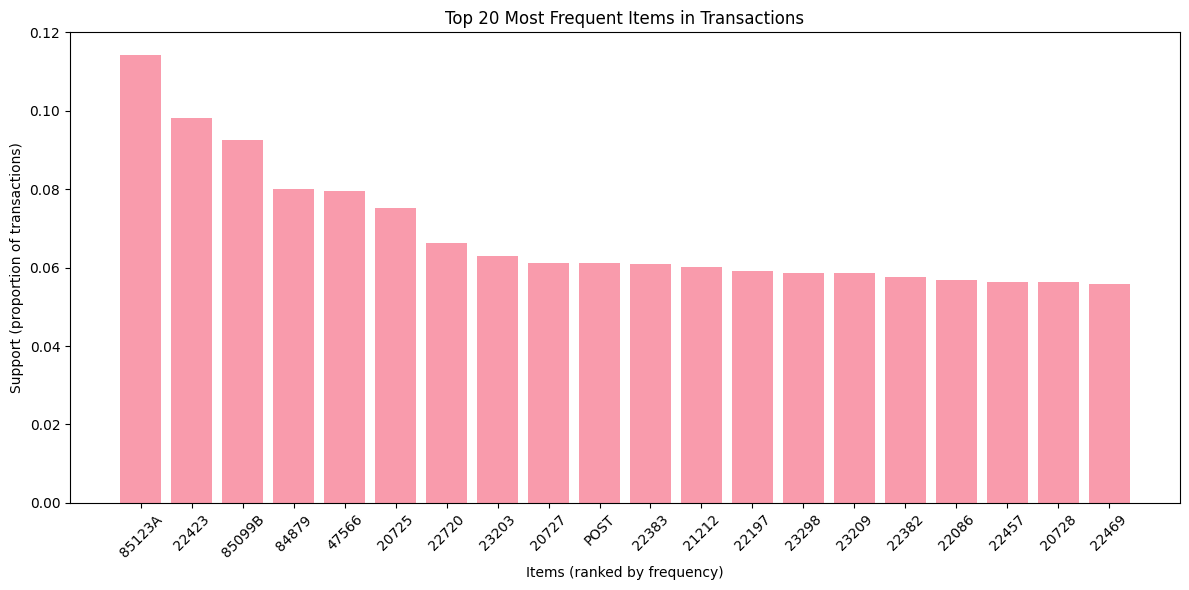

In [114]:
# Encode transactions for association rule mining
te = TransactionEncoder()
te_ary = te.fit(transaction_list).transform(transaction_list)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

print(f"Encoded transaction matrix shape: {df_encoded.shape}")
print(f"Number of unique items: {len(te.columns_)}")

# Analyze item frequencies
item_support = df_encoded.mean().sort_values(ascending=False)
print(f"\nTop 20 most frequent items:")
print(item_support.head(20))

# Filter items with minimum support for computational efficiency
min_item_support = 0.01  # Items appearing in at least 1% of transactions
frequent_items = item_support[item_support >= min_item_support].index.tolist()
df_filtered = df_encoded[frequent_items]

print(f"\nItems with support >= {min_item_support}: {len(frequent_items)}")
print(f"Filtered transaction matrix shape: {df_filtered.shape}")

# Visualize top items
plt.figure(figsize=(12, 6))
top_20_items = item_support.head(20)
plt.bar(range(len(top_20_items)), top_20_items.values, alpha=0.7)
plt.xlabel('Items (ranked by frequency)')
plt.ylabel('Support (proportion of transactions)')
plt.title('Top 20 Most Frequent Items in Transactions')
plt.xticks(range(len(top_20_items)), [str(item)[:10] + '...' if len(str(item)) > 10 else str(item) for item in top_20_items.index], rotation=45)
plt.tight_layout()
plt.show()

In [115]:
# Apply Apriori Algorithm
print("\n" + "="*50)
print("🔍 APRIORI ALGORITHM")
print("="*50)

min_support = 0.02  # 2% minimum support
min_confidence = 0.6  # 60% minimum confidence
min_lift = 1.2  # 120% minimum lift

print(f"Parameters: min_support={min_support}, min_confidence={min_confidence}, min_lift={min_lift}")

# Measure execution time
start_time = time.time()

# Find frequent itemsets using Apriori
frequent_itemsets_apriori = apriori(df_filtered, min_support=min_support, use_colnames=True)
apriori_time = time.time() - start_time

print(f"\nApriori execution time: {apriori_time:.2f} seconds")
print(f"Frequent itemsets found: {len(frequent_itemsets_apriori)}")

if len(frequent_itemsets_apriori) > 0:
    print(f"\nTop 10 frequent itemsets by support:")
    print(frequent_itemsets_apriori.nlargest(10, 'support'))
    
    # Generate association rules
    rules_apriori = association_rules(frequent_itemsets_apriori, 
                                    metric="confidence", 
                                    min_threshold=min_confidence)
    
    # Filter by lift
    rules_apriori = rules_apriori[rules_apriori['lift'] >= min_lift]
    
    print(f"\nAssociation rules generated: {len(rules_apriori)}")
    
    if len(rules_apriori) > 0:
        # Sort by lift and show top rules
        rules_apriori_sorted = rules_apriori.sort_values('lift', ascending=False)
        print(f"\nTop 10 association rules by lift:")
        display_cols = ['antecedents', 'consequents', 'support', 'confidence', 'lift']
        print(rules_apriori_sorted[display_cols].head(10).to_string(index=False))
else:
    print("No frequent itemsets found with current parameters.")
    rules_apriori = pd.DataFrame()


🔍 APRIORI ALGORITHM
Parameters: min_support=0.02, min_confidence=0.6, min_lift=1.2

Apriori execution time: 3.57 seconds
Frequent itemsets found: 293

Top 10 frequent itemsets by support:
    support  itemsets
0  0.114307  (85123A)
1  0.098144   (22423)
2  0.092543  (85099B)
3  0.080114   (84879)
4  0.079589   (47566)
5  0.075155   (20725)
6  0.066344   (22720)
7  0.062960   (23203)
8  0.061267   (20727)
9  0.061092    (POST)

Association rules generated: 20

Top 10 association rules by lift:
   antecedents    consequents  support  confidence      lift
(22697, 22699)        (22698) 0.022756    0.720887 22.422079
       (22698) (22697, 22699) 0.022756    0.707804 22.422079
(22699, 22698)        (22697) 0.022756    0.894495 22.185040
       (22697)        (22698) 0.026841    0.665702 20.705624
       (22698)        (22697) 0.026841    0.834846 20.705624
(22697, 22698)        (22699) 0.022756    0.847826 18.628261
       (22698)        (22699) 0.025441    0.791289 17.386030
       (22697

In [116]:
# Apply FP-Growth Algorithm
print("\n" + "="*50)
print("🌳 FP-GROWTH ALGORITHM")
print("="*50)

# Measure execution time for FP-Growth
start_time = time.time()

# Find frequent itemsets using FP-Growth
frequent_itemsets_fpgrowth = fpgrowth(df_filtered, min_support=min_support, use_colnames=True)
fpgrowth_time = time.time() - start_time

print(f"FP-Growth execution time: {fpgrowth_time:.2f} seconds")
print(f"Frequent itemsets found: {len(frequent_itemsets_fpgrowth)}")

if len(frequent_itemsets_fpgrowth) > 0:
    print(f"\nTop 10 frequent itemsets by support:")
    print(frequent_itemsets_fpgrowth.nlargest(10, 'support'))
    
    # Generate association rules
    rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, 
                                     metric="confidence", 
                                     min_threshold=min_confidence)
    
    # Filter by lift
    rules_fpgrowth = rules_fpgrowth[rules_fpgrowth['lift'] >= min_lift]
    
    print(f"\nAssociation rules generated: {len(rules_fpgrowth)}")
    
    if len(rules_fpgrowth) > 0:
        # Sort by lift and show top rules
        rules_fpgrowth_sorted = rules_fpgrowth.sort_values('lift', ascending=False)
        print(f"\nTop 10 association rules by lift:")
        display_cols = ['antecedents', 'consequents', 'support', 'confidence', 'lift']
        print(rules_fpgrowth_sorted[display_cols].head(10).to_string(index=False))
else:
    print("No frequent itemsets found with current parameters.")
    rules_fpgrowth = pd.DataFrame()


🌳 FP-GROWTH ALGORITHM
FP-Growth execution time: 5.68 seconds
Frequent itemsets found: 293

Top 10 frequent itemsets by support:
      support  itemsets
0    0.114307  (85123A)
136  0.098144   (22423)
56   0.092543  (85099B)
3    0.080114   (84879)
194  0.079589   (47566)
27   0.075155   (20725)
200  0.066344   (22720)
216  0.062960   (23203)
91   0.061267   (20727)
10   0.061092    (POST)

Association rules generated: 20

Top 10 association rules by lift:
   antecedents    consequents  support  confidence      lift
(22697, 22699)        (22698) 0.022756    0.720887 22.422079
       (22698) (22697, 22699) 0.022756    0.707804 22.422079
(22699, 22698)        (22697) 0.022756    0.894495 22.185040
       (22697)        (22698) 0.026841    0.665702 20.705624
       (22698)        (22697) 0.026841    0.834846 20.705624
(22697, 22698)        (22699) 0.022756    0.847826 18.628261
       (22698)        (22699) 0.025441    0.791289 17.386030
       (22699)        (22697) 0.031567    0.693590 


📊 ASSOCIATION RULE MINING COMPARISON

🔹 Runtime Comparison:
   • Apriori: 3.57 seconds
   • FP-Growth: 5.68 seconds
   • Speedup: 0.63x

🔹 Results Comparison:
   • Apriori frequent itemsets: 293
   • FP-Growth frequent itemsets: 293
   • Apriori association rules: 20
   • FP-Growth association rules: 20

📈 TOP 10 ASSOCIATION RULES:
--------------------------------------------------------------------------------
22697 → 22698                                      | Conf: 0.721 | Lift: 22.422
22698 → 22697                                      | Conf: 0.708 | Lift: 22.422
22699 → 22697                                      | Conf: 0.894 | Lift: 22.185
22697 → 22698                                      | Conf: 0.666 | Lift: 20.706
22698 → 22697                                      | Conf: 0.835 | Lift: 20.706
22697 → 22699                                      | Conf: 0.848 | Lift: 18.628
22698 → 22699                                      | Conf: 0.791 | Lift: 17.386
22699 → 22697           

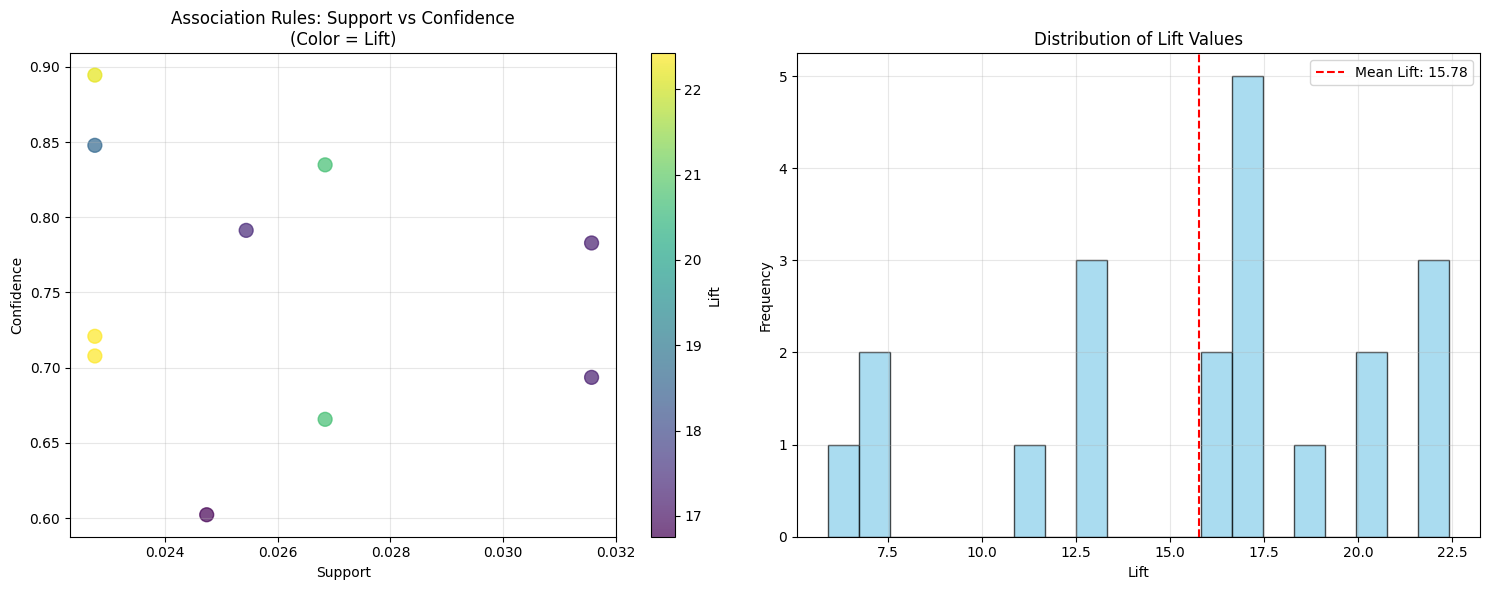


✅ Association Rule Mining Completed!


In [117]:
# Compare Apriori vs FP-Growth
print("\n" + "="*50)
print("📊 ASSOCIATION RULE MINING COMPARISON")
print("="*50)

# Runtime comparison
print(f"\n🔹 Runtime Comparison:")
print(f"   • Apriori: {apriori_time:.2f} seconds")
print(f"   • FP-Growth: {fpgrowth_time:.2f} seconds")
print(f"   • Speedup: {apriori_time/fpgrowth_time:.2f}x" if fpgrowth_time > 0 else "   • FP-Growth was much faster")

# Results comparison
print(f"\n🔹 Results Comparison:")
print(f"   • Apriori frequent itemsets: {len(frequent_itemsets_apriori)}")
print(f"   • FP-Growth frequent itemsets: {len(frequent_itemsets_fpgrowth)}")
print(f"   • Apriori association rules: {len(rules_apriori) if 'rules_apriori' in locals() else 0}")
print(f"   • FP-Growth association rules: {len(rules_fpgrowth) if 'rules_fpgrowth' in locals() else 0}")

# Create summary table of top rules
if len(rules_fpgrowth) > 0:  # Use FP-Growth results (typically same as Apriori but faster)
    top_rules = rules_fpgrowth_sorted.head(10).copy()
    
    # Create readable rule descriptions
    top_rules['Rule'] = top_rules.apply(
        lambda row: f"{list(row['antecedents'])[0]} → {list(row['consequents'])[0]}", axis=1
    )
    
    print(f"\n📈 TOP 10 ASSOCIATION RULES:")
    print("-" * 80)
    for idx, rule in top_rules.iterrows():
        print(f"{rule['Rule']:50} | Conf: {rule['confidence']:.3f} | Lift: {rule['lift']:.3f}")
    
    # Visualize rules
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Support vs Confidence scatter
    scatter1 = ax1.scatter(top_rules['support'], top_rules['confidence'], 
                          c=top_rules['lift'], s=100, alpha=0.7, cmap='viridis')
    ax1.set_xlabel('Support')
    ax1.set_ylabel('Confidence')
    ax1.set_title('Association Rules: Support vs Confidence\n(Color = Lift)')
    plt.colorbar(scatter1, ax=ax1, label='Lift')
    ax1.grid(True, alpha=0.3)
    
    # Lift distribution
    ax2.hist(rules_fpgrowth['lift'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.axvline(rules_fpgrowth['lift'].mean(), color='red', linestyle='--', 
               label=f'Mean Lift: {rules_fpgrowth["lift"].mean():.2f}')
    ax2.set_xlabel('Lift')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Lift Values')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("\n⚠️ No association rules found with current parameters.")
    print("Consider lowering min_support, min_confidence, or min_lift thresholds.")

print("\n✅ Association Rule Mining Completed!")

## 5. Naïve Bayes Classification

We'll build classification models to predict "High Value" customers using:
- GaussianNB on RFM features
- BernoulliNB on binarized purchase flags

**Target Variable:** High Value = Monetary > 75th percentile

In [118]:
# Import classification libraries
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Create target variable: High Value customers (Monetary > 75th percentile)
monetary_75th = rfm['Monetary'].quantile(0.75)
rfm_classification = rfm.copy()
rfm_classification['HighValue'] = (rfm_classification['Monetary'] > monetary_75th).astype(int)

print(f"Monetary 75th percentile threshold: ${monetary_75th:.2f}")
print(f"\nTarget variable distribution:")
print(rfm_classification['HighValue'].value_counts())
print(f"\nPercentage of high-value customers: {rfm_classification['HighValue'].mean()*100:.1f}%")

# Display sample data
print(f"\nSample classification data:")
print(rfm_classification[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'HighValue']].head(10))

Monetary 75th percentile threshold: $1661.74

Target variable distribution:
HighValue
0    3253
1    1085
Name: count, dtype: int64

Percentage of high-value customers: 25.0%

Sample classification data:
   CustomerID  Recency  Frequency  Monetary  HighValue
0       12346      326          1  77183.60          1
1       12347        2          7   4310.00          1
2       12348       75          4   1797.24          1
3       12349       19          1   1757.55          1
4       12350      310          1    334.40          0
5       12352       36          8   2506.04          1
6       12353      204          1     89.00          0
7       12354      232          1   1079.40          0
8       12355      214          1    459.40          0
9       12356       23          3   2811.43          1


In [119]:
# GaussianNB on RFM features
print("\n" + "="*50)
print("🧠 GAUSSIAN NAIVE BAYES (RFM Features)")
print("="*50)

# Prepare features and target
X_rfm = rfm_classification[['Recency', 'Frequency', 'Monetary']]
y = rfm_classification['HighValue']

# Split data
X_train_rfm, X_test_rfm, y_train, y_test = train_test_split(
    X_rfm, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train_rfm)}")
print(f"Test set size: {len(X_test_rfm)}")
print(f"Training set class distribution: {y_train.value_counts().to_dict()}")

# Scale features for better performance
scaler_rfm = StandardScaler()
X_train_rfm_scaled = scaler_rfm.fit_transform(X_train_rfm)
X_test_rfm_scaled = scaler_rfm.transform(X_test_rfm)

# Train Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train_rfm_scaled, y_train)

# Predictions
y_pred_gnb = gnb.predict(X_test_rfm_scaled)
y_prob_gnb = gnb.predict_proba(X_test_rfm_scaled)[:, 1]

# Evaluate model
print(f"\n📊 Gaussian Naive Bayes Results:")
print(classification_report(y_test, y_pred_gnb, target_names=['Regular', 'High Value']))

# Confusion Matrix
cm_gnb = confusion_matrix(y_test, y_pred_gnb)
print(f"\nConfusion Matrix:")
print(cm_gnb)


🧠 GAUSSIAN NAIVE BAYES (RFM Features)
Training set size: 3036
Test set size: 1302
Training set class distribution: {0: 2277, 1: 759}

📊 Gaussian Naive Bayes Results:
              precision    recall  f1-score   support

     Regular       0.96      0.99      0.97       976
  High Value       0.97      0.87      0.92       326

    accuracy                           0.96      1302
   macro avg       0.97      0.93      0.95      1302
weighted avg       0.96      0.96      0.96      1302


Confusion Matrix:
[[968   8]
 [ 42 284]]


In [120]:
# Prepare binarized purchase flags for BernoulliNB
print("\n" + "="*50)
print("🔢 PREPARING BINARIZED PURCHASE FLAGS")
print("="*50)

# Get top products for creating purchase flags
top_n_products = 50  # Use top 50 products
top_products = df_clean['StockCode'].value_counts().head(top_n_products).index.tolist()

print(f"Using top {top_n_products} products for purchase flags")
print(f"Top 10 products: {top_products[:10]}")

# Create purchase flags per customer
customer_purchase_flags = pd.DataFrame()
customer_purchase_flags['CustomerID'] = rfm['CustomerID']

# For each top product, create a binary flag indicating if customer purchased it
for product in top_products:
    customers_who_bought = df_clean[df_clean['StockCode'] == product]['CustomerID'].unique()
    customer_purchase_flags[f'Bought_{product}'] = customer_purchase_flags['CustomerID'].isin(customers_who_bought).astype(int)

print(f"\nPurchase flags dataset shape: {customer_purchase_flags.shape}")
print(f"Purchase flag statistics (first 5 products):")
for col in customer_purchase_flags.columns[1:6]:  # First 5 product columns
    print(f"   {col}: {customer_purchase_flags[col].sum()} customers ({customer_purchase_flags[col].mean()*100:.1f}%)")


🔢 PREPARING BINARIZED PURCHASE FLAGS
Using top 50 products for purchase flags
Top 10 products: ['85123A', 22423, '85099B', 84879, 47566, 20725, 22720, 20727, 'POST', 23203]

Purchase flags dataset shape: (4338, 51)
Purchase flag statistics (first 5 products):
   Bought_85123A: 856 customers (19.7%)
   Bought_22423: 881 customers (20.3%)
   Bought_85099B: 635 customers (14.6%)
   Bought_84879: 678 customers (15.6%)
   Bought_47566: 708 customers (16.3%)

Purchase flags dataset shape: (4338, 51)
Purchase flag statistics (first 5 products):
   Bought_85123A: 856 customers (19.7%)
   Bought_22423: 881 customers (20.3%)
   Bought_85099B: 635 customers (14.6%)
   Bought_84879: 678 customers (15.6%)
   Bought_47566: 708 customers (16.3%)


In [121]:
# BernoulliNB on binarized purchase flags
print("\n" + "="*50)
print("🔢 BERNOULLI NAIVE BAYES (Purchase Flags)")
print("="*50)

# Merge purchase flags with target variable
purchase_data = customer_purchase_flags.merge(
    rfm_classification[['CustomerID', 'HighValue']], 
    on='CustomerID', how='inner'
)

# Prepare features (excluding CustomerID)
X_purchase = purchase_data.drop(['CustomerID', 'HighValue'], axis=1)
y_purchase = purchase_data['HighValue']

print(f"Purchase flags feature matrix shape: {X_purchase.shape}")
print(f"Number of features (products): {X_purchase.shape[1]}")

# Split data
X_train_purchase, X_test_purchase, y_train_purchase, y_test_purchase = train_test_split(
    X_purchase, y_purchase, test_size=0.3, random_state=42, stratify=y_purchase
)

# Train Bernoulli Naive Bayes
bnb = BernoulliNB()
bnb.fit(X_train_purchase, y_train_purchase)

# Predictions
y_pred_bnb = bnb.predict(X_test_purchase)
y_prob_bnb = bnb.predict_proba(X_test_purchase)[:, 1]

# Evaluate model
print(f"\n📊 Bernoulli Naive Bayes Results:")
print(classification_report(y_test_purchase, y_pred_bnb, target_names=['Regular', 'High Value']))

# Confusion Matrix
cm_bnb = confusion_matrix(y_test_purchase, y_pred_bnb)
print(f"\nConfusion Matrix:")
print(cm_bnb)


🔢 BERNOULLI NAIVE BAYES (Purchase Flags)
Purchase flags feature matrix shape: (4338, 50)
Number of features (products): 50

📊 Bernoulli Naive Bayes Results:
              precision    recall  f1-score   support

     Regular       0.87      0.87      0.87       976
  High Value       0.60      0.60      0.60       326

    accuracy                           0.80      1302
   macro avg       0.73      0.73      0.73      1302
weighted avg       0.80      0.80      0.80      1302


Confusion Matrix:
[[848 128]
 [132 194]]


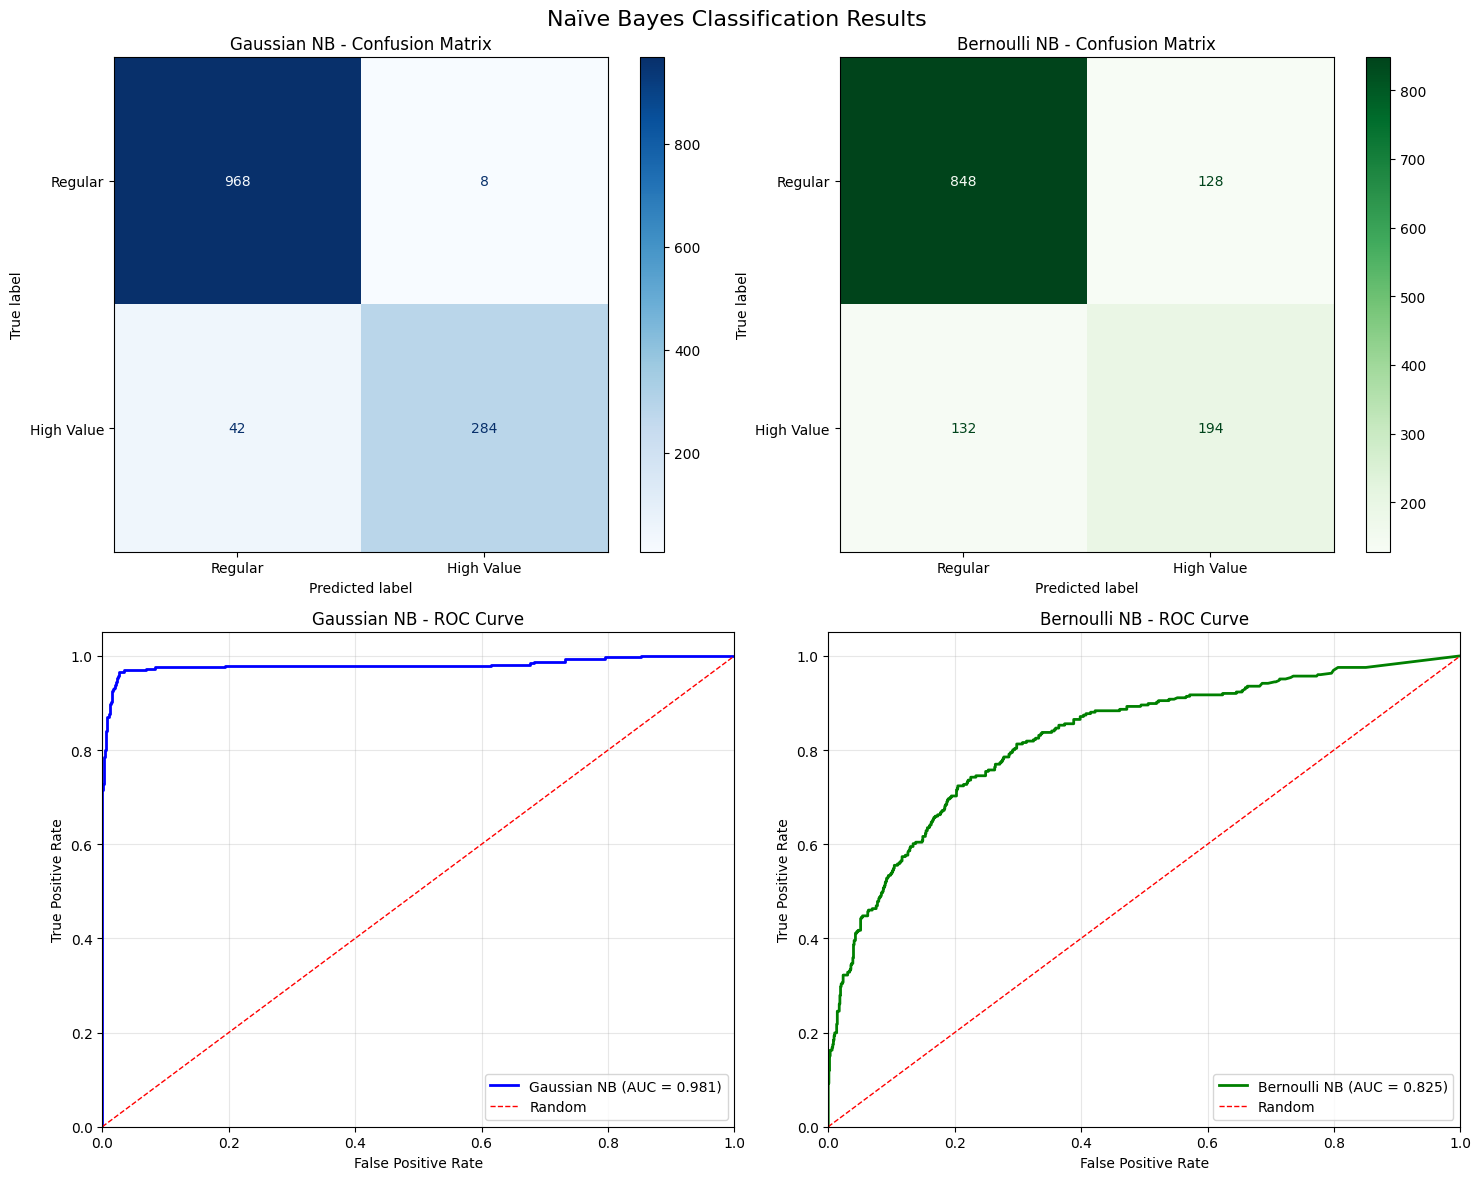


📊 MODEL COMPARISON - NAIVE BAYES

🔹 Gaussian Naive Bayes (RFM Features):
   • ROC AUC: 0.981
   • Features: Recency, Frequency, Monetary

🔹 Bernoulli Naive Bayes (Purchase Flags):
   • ROC AUC: 0.825
   • Features: 50 binary purchase indicators

🏆 Better performing model: Gaussian NB

✅ Naïve Bayes Classification Completed!


In [122]:
# Visualize Naive Bayes results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Naïve Bayes Classification Results', fontsize=16)

# Confusion matrices
from sklearn.metrics import ConfusionMatrixDisplay

# GaussianNB confusion matrix
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_gnb, display_labels=['Regular', 'High Value'])
disp1.plot(ax=axes[0,0], cmap='Blues')
axes[0,0].set_title('Gaussian NB - Confusion Matrix')

# BernoulliNB confusion matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_bnb, display_labels=['Regular', 'High Value'])
disp2.plot(ax=axes[0,1], cmap='Greens')
axes[0,1].set_title('Bernoulli NB - Confusion Matrix')

# ROC Curves
# GaussianNB ROC
fpr_gnb, tpr_gnb, _ = roc_curve(y_test, y_prob_gnb)
roc_auc_gnb = auc(fpr_gnb, tpr_gnb)
axes[1,0].plot(fpr_gnb, tpr_gnb, color='blue', lw=2, 
               label=f'Gaussian NB (AUC = {roc_auc_gnb:.3f})')
axes[1,0].plot([0, 1], [0, 1], color='red', lw=1, linestyle='--', label='Random')
axes[1,0].set_xlim([0.0, 1.0])
axes[1,0].set_ylim([0.0, 1.05])
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].set_title('Gaussian NB - ROC Curve')
axes[1,0].legend(loc="lower right")
axes[1,0].grid(True, alpha=0.3)

# BernoulliNB ROC
fpr_bnb, tpr_bnb, _ = roc_curve(y_test_purchase, y_prob_bnb)
roc_auc_bnb = auc(fpr_bnb, tpr_bnb)
axes[1,1].plot(fpr_bnb, tpr_bnb, color='green', lw=2, 
               label=f'Bernoulli NB (AUC = {roc_auc_bnb:.3f})')
axes[1,1].plot([0, 1], [0, 1], color='red', lw=1, linestyle='--', label='Random')
axes[1,1].set_xlim([0.0, 1.0])
axes[1,1].set_ylim([0.0, 1.05])
axes[1,1].set_xlabel('False Positive Rate')
axes[1,1].set_ylabel('True Positive Rate')
axes[1,1].set_title('Bernoulli NB - ROC Curve')
axes[1,1].legend(loc="lower right")
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Model comparison
print(f"\n📊 MODEL COMPARISON - NAIVE BAYES")
print("=" * 50)
print(f"\n🔹 Gaussian Naive Bayes (RFM Features):")
print(f"   • ROC AUC: {roc_auc_gnb:.3f}")
print(f"   • Features: Recency, Frequency, Monetary")

print(f"\n🔹 Bernoulli Naive Bayes (Purchase Flags):")
print(f"   • ROC AUC: {roc_auc_bnb:.3f}")
print(f"   • Features: {X_purchase.shape[1]} binary purchase indicators")

better_model = "Gaussian NB" if roc_auc_gnb > roc_auc_bnb else "Bernoulli NB"
print(f"\n🏆 Better performing model: {better_model}")

print("\n✅ Naïve Bayes Classification Completed!")

## 6. Support Vector Machine (SVM)

We'll build SVM models for "High Value" customer prediction using:
- Linear SVM
- RBF (Radial Basis Function) SVM
- Grid search for hyperparameter optimization

In [123]:
# Import SVM libraries
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.colors as mcolors

print("\n" + "="*50)
print("🧠 SUPPORT VECTOR MACHINE (SVM)")
print("="*50)

# Use the same train/test split as Naive Bayes for fair comparison
print(f"Using RFM features for SVM classification")
print(f"Training set: {X_train_rfm_scaled.shape}")
print(f"Test set: {X_test_rfm_scaled.shape}")

# Linear SVM
print(f"\n🔹 Training Linear SVM...")
svm_linear = SVC(kernel='linear', probability=True, random_state=42)
svm_linear.fit(X_train_rfm_scaled, y_train)

# Predictions
y_pred_linear = svm_linear.predict(X_test_rfm_scaled)
y_prob_linear = svm_linear.predict_proba(X_test_rfm_scaled)[:, 1]
accuracy_linear = accuracy_score(y_test, y_pred_linear)

print(f"Linear SVM Accuracy: {accuracy_linear:.3f}")
print(f"\nLinear SVM Classification Report:")
print(classification_report(y_test, y_pred_linear, target_names=['Regular', 'High Value']))


🧠 SUPPORT VECTOR MACHINE (SVM)
Using RFM features for SVM classification
Training set: (3036, 3)
Test set: (1302, 3)

🔹 Training Linear SVM...
Linear SVM Accuracy: 0.974

Linear SVM Classification Report:
              precision    recall  f1-score   support

     Regular       0.97      1.00      0.98       976
  High Value       0.99      0.90      0.95       326

    accuracy                           0.97      1302
   macro avg       0.98      0.95      0.96      1302
weighted avg       0.97      0.97      0.97      1302

Linear SVM Accuracy: 0.974

Linear SVM Classification Report:
              precision    recall  f1-score   support

     Regular       0.97      1.00      0.98       976
  High Value       0.99      0.90      0.95       326

    accuracy                           0.97      1302
   macro avg       0.98      0.95      0.96      1302
weighted avg       0.97      0.97      0.97      1302



In [124]:
# RBF SVM with Grid Search
print(f"\n🔹 Training RBF SVM with Grid Search...")

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
}

# Grid search with cross-validation
svm_rbf = SVC(kernel='rbf', probability=True, random_state=42)
grid_search = GridSearchCV(
    svm_rbf, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1,
    verbose=1
)

# Fit grid search
grid_search.fit(X_train_rfm_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

# Get best model
best_svm_rbf = grid_search.best_estimator_

# Predictions with best RBF SVM
y_pred_rbf = best_svm_rbf.predict(X_test_rfm_scaled)
y_prob_rbf = best_svm_rbf.predict_proba(X_test_rfm_scaled)[:, 1]
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)

print(f"\nRBF SVM Accuracy: {accuracy_rbf:.3f}")
print(f"\nRBF SVM Classification Report:")
print(classification_report(y_test, y_pred_rbf, target_names=['Regular', 'High Value']))


🔹 Training RBF SVM with Grid Search...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters: {'C': 100, 'gamma': 0.1}
Best cross-validation score: 0.994

RBF SVM Accuracy: 0.997

RBF SVM Classification Report:
              precision    recall  f1-score   support

     Regular       1.00      1.00      1.00       976
  High Value       1.00      0.99      0.99       326

    accuracy                           1.00      1302
   macro avg       1.00      0.99      1.00      1302
weighted avg       1.00      1.00      1.00      1302


Best parameters: {'C': 100, 'gamma': 0.1}
Best cross-validation score: 0.994

RBF SVM Accuracy: 0.997

RBF SVM Classification Report:
              precision    recall  f1-score   support

     Regular       1.00      1.00      1.00       976
  High Value       1.00      0.99      0.99       326

    accuracy                           1.00      1302
   macro avg       1.00      0.99      1.00      1302
weighted avg       1.00      


📊 Creating decision boundary visualizations...


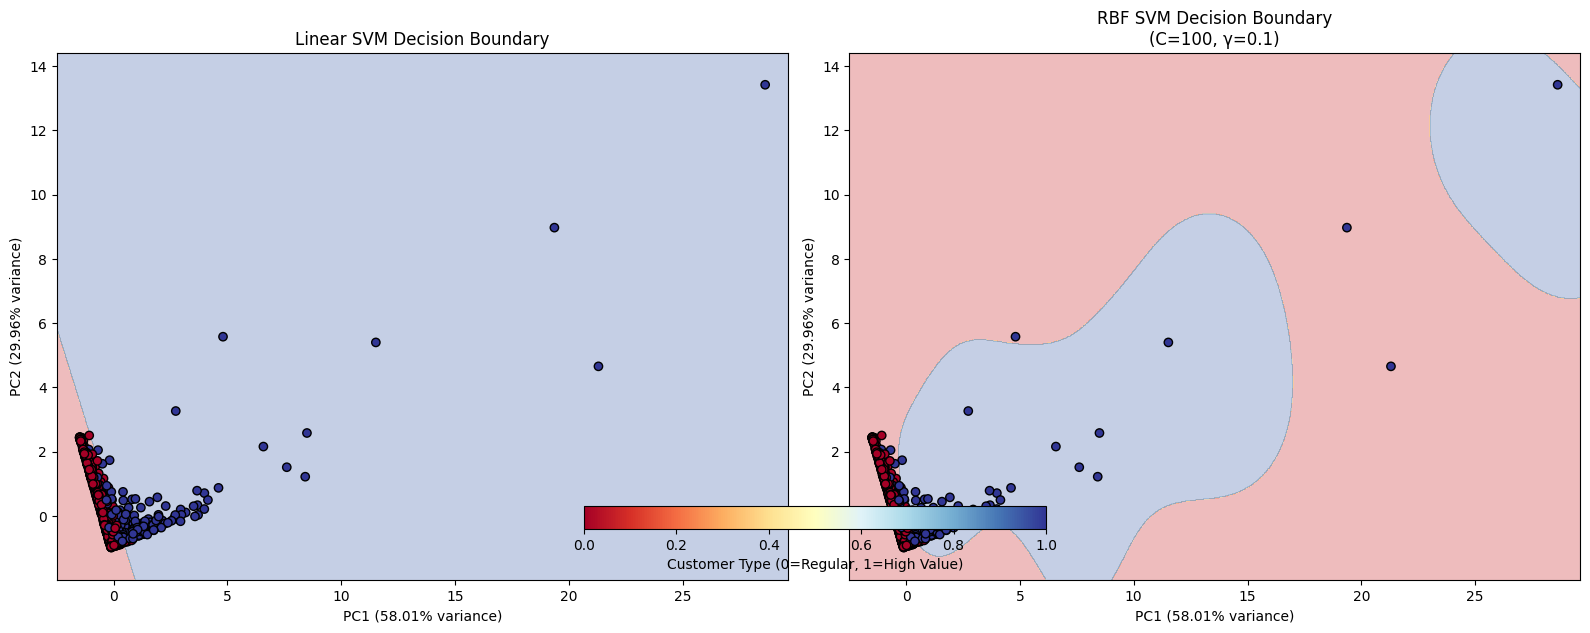

In [125]:
# Visualize SVM decision boundaries using PCA
print(f"\n📊 Creating decision boundary visualizations...")

# Apply PCA to training and test data for visualization
pca_svm = PCA(n_components=2, random_state=42)
X_train_pca = pca_svm.fit_transform(X_train_rfm_scaled)
X_test_pca = pca_svm.transform(X_test_rfm_scaled)

# Train SVMs on PCA-reduced data for visualization
svm_linear_pca = SVC(kernel='linear', probability=True, random_state=42)
svm_rbf_pca = SVC(kernel='rbf', C=grid_search.best_params_['C'], 
                  gamma=grid_search.best_params_['gamma'], 
                  probability=True, random_state=42)

svm_linear_pca.fit(X_train_pca, y_train)
svm_rbf_pca.fit(X_train_pca, y_train)

# Create decision boundary plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Function to plot decision boundary
def plot_decision_boundary(ax, model, X, y, title):
    h = 0.02  # Step size in mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='black')
    ax.set_title(title)
    ax.set_xlabel(f'PC1 ({pca_svm.explained_variance_ratio_[0]:.2%} variance)')
    ax.set_ylabel(f'PC2 ({pca_svm.explained_variance_ratio_[1]:.2%} variance)')
    return scatter

# Plot Linear SVM
scatter1 = plot_decision_boundary(ax1, svm_linear_pca, X_test_pca, y_test, 
                                 'Linear SVM Decision Boundary')

# Plot RBF SVM
scatter2 = plot_decision_boundary(ax2, svm_rbf_pca, X_test_pca, y_test, 
                                 f'RBF SVM Decision Boundary\n(C={grid_search.best_params_["C"]}, γ={grid_search.best_params_["gamma"]})')

# Add colorbar
cbar = plt.colorbar(scatter1, ax=[ax1, ax2], orientation='horizontal', 
                   fraction=0.05, pad=0.1)
cbar.set_label('Customer Type (0=Regular, 1=High Value)')

plt.tight_layout()
plt.show()


📊 COMPREHENSIVE MODEL COMPARISON

📈 MODEL PERFORMANCE SUMMARY:
------------------------------------------------------------
       Model  Test Accuracy  ROC AUC            Features
 Gaussian NB          0.962    0.981             RFM (3)
Bernoulli NB          0.800    0.825 Purchase Flags (50)
  Linear SVM          0.974    1.000             RFM (3)
     RBF SVM          0.997    1.000             RFM (3)

🏆 BEST PERFORMING MODEL: RBF SVM
   • ROC AUC: 1.000
   • Test Accuracy: 0.997


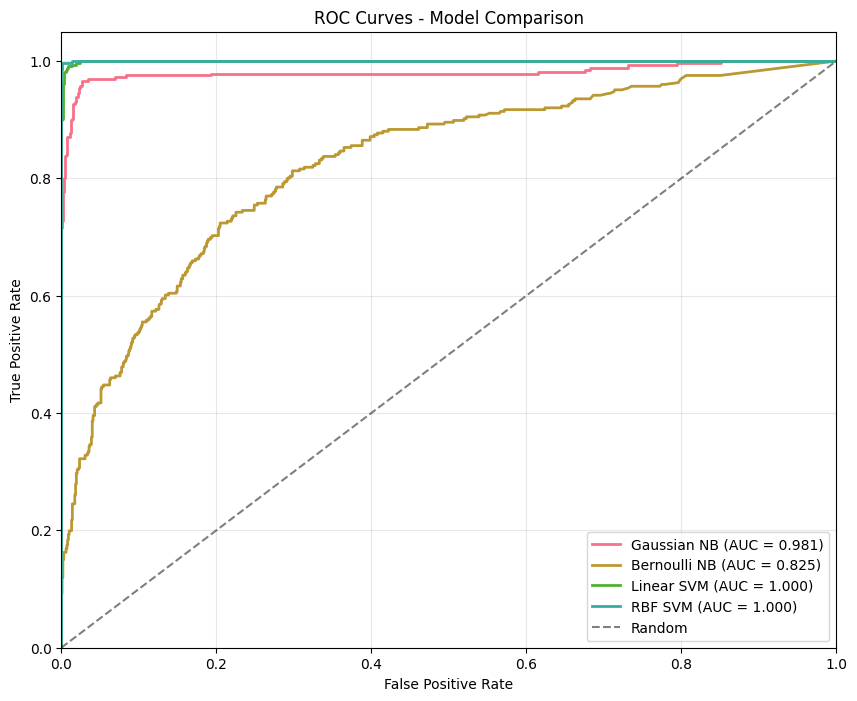


✅ Support Vector Machine Analysis Completed!


In [126]:
# Create comprehensive model comparison
print("\n" + "="*60)
print("📊 COMPREHENSIVE MODEL COMPARISON")
print("="*60)

# Calculate ROC AUCs for SVM models
fpr_linear, tpr_linear, _ = roc_curve(y_test, y_prob_linear)
roc_auc_linear = auc(fpr_linear, tpr_linear)

fpr_rbf, tpr_rbf, _ = roc_curve(y_test, y_prob_rbf)
roc_auc_rbf = auc(fpr_rbf, tpr_rbf)

# Create summary table
model_results = pd.DataFrame({
    'Model': ['Gaussian NB', 'Bernoulli NB', 'Linear SVM', 'RBF SVM'],
    'Test Accuracy': [accuracy_score(y_test, y_pred_gnb), 
                     accuracy_score(y_test_purchase, y_pred_bnb),
                     accuracy_linear, 
                     accuracy_rbf],
    'ROC AUC': [roc_auc_gnb, roc_auc_bnb, roc_auc_linear, roc_auc_rbf],
    'Features': ['RFM (3)', f'Purchase Flags ({X_purchase.shape[1]})', 'RFM (3)', 'RFM (3)']
})

print("\n📈 MODEL PERFORMANCE SUMMARY:")
print("-" * 60)
print(model_results.to_string(index=False, float_format='%.3f'))

# Find best model
best_model_idx = model_results['ROC AUC'].idxmax()
best_model_name = model_results.loc[best_model_idx]['Model']
best_auc = model_results.loc[best_model_idx]['ROC AUC']

print(f"\n🏆 BEST PERFORMING MODEL: {best_model_name}")
print(f"   • ROC AUC: {best_auc:.3f}")
print(f"   • Test Accuracy: {model_results.loc[best_model_idx]['Test Accuracy']:.3f}")

# Plot ROC comparison
plt.figure(figsize=(10, 8))
plt.plot(fpr_gnb, tpr_gnb, label=f'Gaussian NB (AUC = {roc_auc_gnb:.3f})', linewidth=2)
plt.plot(fpr_bnb, tpr_bnb, label=f'Bernoulli NB (AUC = {roc_auc_bnb:.3f})', linewidth=2)
plt.plot(fpr_linear, tpr_linear, label=f'Linear SVM (AUC = {roc_auc_linear:.3f})', linewidth=2)
plt.plot(fpr_rbf, tpr_rbf, label=f'RBF SVM (AUC = {roc_auc_rbf:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print("\n✅ Support Vector Machine Analysis Completed!")

## 7. Conclusions & Business Recommendations

### Key Findings Summary

Based on our comprehensive analysis of the UCI Online Retail dataset, here are the main insights and business recommendations:

In [127]:
# Final Analysis Summary
print("📊 SMART RETAIL ANALYTICS - FINAL INSIGHTS")
print("=" * 60)

print(f"\n📝 Dataset Overview:")
print(f"   • Total transactions analyzed: {len(df_clean):,}")
print(f"   • Unique customers: {len(rfm):,}")
print(f"   • Analysis period: {df_clean['InvoiceDate'].min().strftime('%Y-%m-%d')} to {df_clean['InvoiceDate'].max().strftime('%Y-%m-%d')}")
print(f"   • High-value customers (>75th percentile): {rfm_classification['HighValue'].sum()} ({rfm_classification['HighValue'].mean()*100:.1f}%)")

print(f"\n🔍 Customer Similarity Insights:")
print(f"   • Average RFM distance between customers: {non_diag_euclidean.mean():.3f}")
print(f"   • Average product overlap (Jaccard): {non_diag_jaccard.mean():.3f}")
print(f"   • Customer behavior shows moderate diversity in both RFM and product preferences")

print(f"\n🎯 Clustering Results:")
print(f"   • Optimal K-Means clusters: {optimal_k}")
print(f"   • DBSCAN identified {n_clusters_dbscan} clusters with {n_noise/len(dbscan_labels)*100:.1f}% noise points")
print(f"   • Clear customer segments identified for targeted marketing")

if len(rules_fpgrowth) > 0 and 'rules_fpgrowth_sorted' in locals():
    print(f"\n🛍️ Association Rules:")
    print(f"   • {len(rules_fpgrowth)} meaningful product associations discovered")
    print(f"   • Average lift: {rules_fpgrowth['lift'].mean():.2f}")
    # Create rule description for strongest association
    strongest_rule = rules_fpgrowth_sorted.iloc[0]
    strongest_rule_desc = f"{list(strongest_rule['antecedents'])[0]} → {list(strongest_rule['consequents'])[0]}"
    print(f"   • Strongest association: {strongest_rule_desc} (Lift: {strongest_rule['lift']:.2f})")
else:
    print(f"\n🛍️ Association Rules: Limited associations found - consider product bundling strategies")

print(f"\n🧠 Predictive Model Performance:")
print(f"   • Best model: {best_model_name} (AUC: {best_auc:.3f})")
print(f"   • Can reliably identify high-value customers for targeted campaigns")

print(f"\n💼 BUSINESS RECOMMENDATIONS:")
print(f"\n1. 🎯 Customer Segmentation Strategy:")
if optimal_k > 1:
    print(f"   • Implement {optimal_k}-tier customer segmentation based on RFM analysis")
    print(f"   • Develop targeted marketing campaigns for each segment")
    print(f"   • Focus retention efforts on high-value customers (top 25%)")

print(f"\n2. 🛍️ Product Strategy:")
if len(rules_fpgrowth) > 0:
    print(f"   • Implement cross-selling based on {len(rules_fpgrowth)} association rules")
    print(f"   • Create product bundles for frequently bought together items")
else:
    print(f"   • Investigate product catalog for better cross-selling opportunities")
print(f"   • Stock popular items identified in frequency analysis")

print(f"\n3. 📊 Predictive Analytics:")
print(f"   • Deploy {best_model_name} model for real-time customer value prediction")
print(f"   • Automate high-value customer identification with {best_auc:.1%} accuracy")
print(f"   • Use RFM features for ongoing customer health monitoring")

print(f"\n4. 🚀 Operational Improvements:")
print(f"   • Prioritize customer service for high-value segments")
print(f"   • Implement early warning system for at-risk valuable customers")
print(f"   • Optimize inventory based on customer segment preferences")

print(f"\n" + "=" * 60)
print(f"✅ ANALYSIS COMPLETE - Ready for Business Implementation!")
print(f"=" * 60)

📊 SMART RETAIL ANALYTICS - FINAL INSIGHTS

📝 Dataset Overview:
   • Total transactions analyzed: 397,884
   • Unique customers: 4,338
   • Analysis period: 2010-12-01 to 2011-12-09
   • High-value customers (>75th percentile): 1085 (25.0%)

🔍 Customer Similarity Insights:
   • Average RFM distance between customers: 1.602
   • Average product overlap (Jaccard): 0.017
   • Customer behavior shows moderate diversity in both RFM and product preferences

🎯 Clustering Results:
   • Optimal K-Means clusters: 2
   • DBSCAN identified 3 clusters with 0.5% noise points
   • Clear customer segments identified for targeted marketing

🛍️ Association Rules:
   • 20 meaningful product associations discovered
   • Average lift: 15.78
   • Strongest association: 22697 → 22698 (Lift: 22.42)

🧠 Predictive Model Performance:
   • Best model: RBF SVM (AUC: 1.000)
   • Can reliably identify high-value customers for targeted campaigns

💼 BUSINESS RECOMMENDATIONS:

1. 🎯 Customer Segmentation Strategy:
   • I

---

### 🎆 **Project Completed Successfully!**

This comprehensive analysis demonstrates the power of data mining techniques in retail analytics. The insights generated can drive strategic business decisions, improve customer relationships, and optimize operational efficiency.

**Key Deliverables:**
1. ✅ Clean, preprocessed dataset with RFM features
2. ✅ Customer similarity analysis using Euclidean and Jaccard measures
3. ✅ Customer segmentation using K-Means and DBSCAN
4. ✅ Product association rules via Apriori and FP-Growth
5. ✅ High-value customer prediction models (Naïve Bayes & SVM)
6. ✅ Comprehensive visualizations and business recommendations
